# Statistics on basic predictors

We are going to limit ourselves to a few basic predictors and later try more advanced techniqes on these basic ones.

The predictors to be used are: DecisionTree, SVM and LogisticRegression.

here we are going to train each of the above predictors and show it's accuracy and error rate reduction on a test dataset. Because in most of our data quotes tend to go up most of the time it will be needed to change the classification threshold from going up or down to going up by more then X percent.

In [3]:
from Utilities.orginizers import LearningData, TrainingData
from sklearn.model_selection import KFold, cross_val_score
from itertools import product
from random import sample
from multiprocessing import Pool
import matplotlib.pyplot as plt
import Utilities
import numpy as np
import warnings
import logging

%matplotlib inline

ld = LearningData()

In [4]:
stock_names = sample(ld.get_stock_names(), 5)
logging.getLogger().setLevel(logging.INFO)
stocks = [TrainingData(sn).add_history(10).set_threshold('middle').get() for sn in stock_names]

INFO:root:TrainingData: name=ACHC, days_forward=1: Median found is 0.01709401709401711
INFO:root:TrainingData: name=BRLI, days_forward=1: Median found is 0.015613382899628317
INFO:root:TrainingData: name=ZMH, days_forward=1: Median found is 0.007828883139170824
INFO:root:TrainingData: name=CE, days_forward=1: Median found is 0.01067392214315609
INFO:root:TrainingData: name=INGN, days_forward=1: Median found is 0.013935882590404954


In [5]:
import os
print("Samples per stock:")
print(os.linesep.join(['{} {}'.format(sn, len(data)) for sn, (data, classes) in zip(stock_names, stocks)]))
print("percent of positive classification per stock")
print(os.linesep.join(['{} {}'.format(sn, float(classes.sum())/len(classes)) for sn, (data, classes) in zip(stock_names, stocks)]))
print(stocks[0][0].describe())

Samples per stock:
ACHC 5688
BRLI 5457
ZMH 3483
CE 2946
INGN 646
percent of positive classification per stock
ACHC 0.49964838255977495
BRLI 0.49990837456477916
ZMH 0.5001435544071203
CE 0.5006788866259335
INGN 0.4969040247678019
            change         close  ex-divident          high          low  \
count  5688.000000  5.688000e+03       5688.0  5.688000e+03  5688.000000   
mean      0.000000  1.598971e-16          0.0 -3.997427e-17     0.000000   
std       1.000088  1.000088e+00          0.0  1.000088e+00     1.000088   
min      -0.476056 -5.846758e-01          0.0 -5.841562e-01    -0.585416   
25%      -0.440200 -5.320371e-01          0.0 -5.322888e-01    -0.531424   
50%      -0.203281 -4.681553e-01          0.0 -4.663215e-01    -0.468606   
75%       0.141143 -2.202938e-01          0.0 -2.205810e-01    -0.225122   
max      58.034014  3.649412e+00          0.0  3.719325e+00     3.667501   

              open   split_ratio        volume  change1_days_before  \
count  5688.000

In [6]:
def run_model(model):
    scores = {sn: [] for sn in stock_names}
    validation_rounds = 3
    for i in range(validation_rounds):
        for sn, (data, classes) in zip(stock_names, stocks):
            scores[sn].append(sum(cross_val_score(model, data, classes))/3) 
    for sn in scores.keys():
        scores[sn] = sum(scores[sn])/validation_rounds
    return scores

def get_best_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if sum(accs.values()) > best_model[0]:
            best_model = (sum(accs.values()), model)
    return best_model

def median(lst):
    quotient, remainder = divmod(len(lst), 2)
    if remainder:
        return sorted(lst)[quotient]
    return sum(sorted(lst)[quotient - 1:quotient + 1]) / 2.

def get_best_median_model(models, accs):
    best_model = (0 , models[0])
    for model, accs in zip(models, accs):
        if median(accs.values()) > best_model[0]:
            best_model = (median(accs.values()), model)
    return best_model

### Decision Tree

In [7]:
from sklearn.tree import DecisionTreeClassifier

# create iterables for all options and use itertools product
criterion=['gini', 'entropy']
max_depth=[1, 2, 5, 10, None]
# using percentages
min_samples_leaf=[0.005, 0.01, 0.02, 0.05, 0.1]

tmodels = [DecisionTreeClassifier(criterion=c, max_depth=md, min_samples_leaf=msl) 
          for c, md, msl in product(criterion, max_depth, min_samples_leaf)]

In [8]:
taccuracies = list(map(run_model, tmodels))

In [9]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for tmodel, taccs in zip(tmodels, taccuracies):
    for tsn, tacc in taccs.items():
        data.append((tmodel.criterion, tmodel.max_depth, tmodel.min_samples_leaf, tsn, tacc))
tresults = DataFrame(data, columns=('criterion', 'max_depth', 'min_samples', 'stock', 'accuracy'))

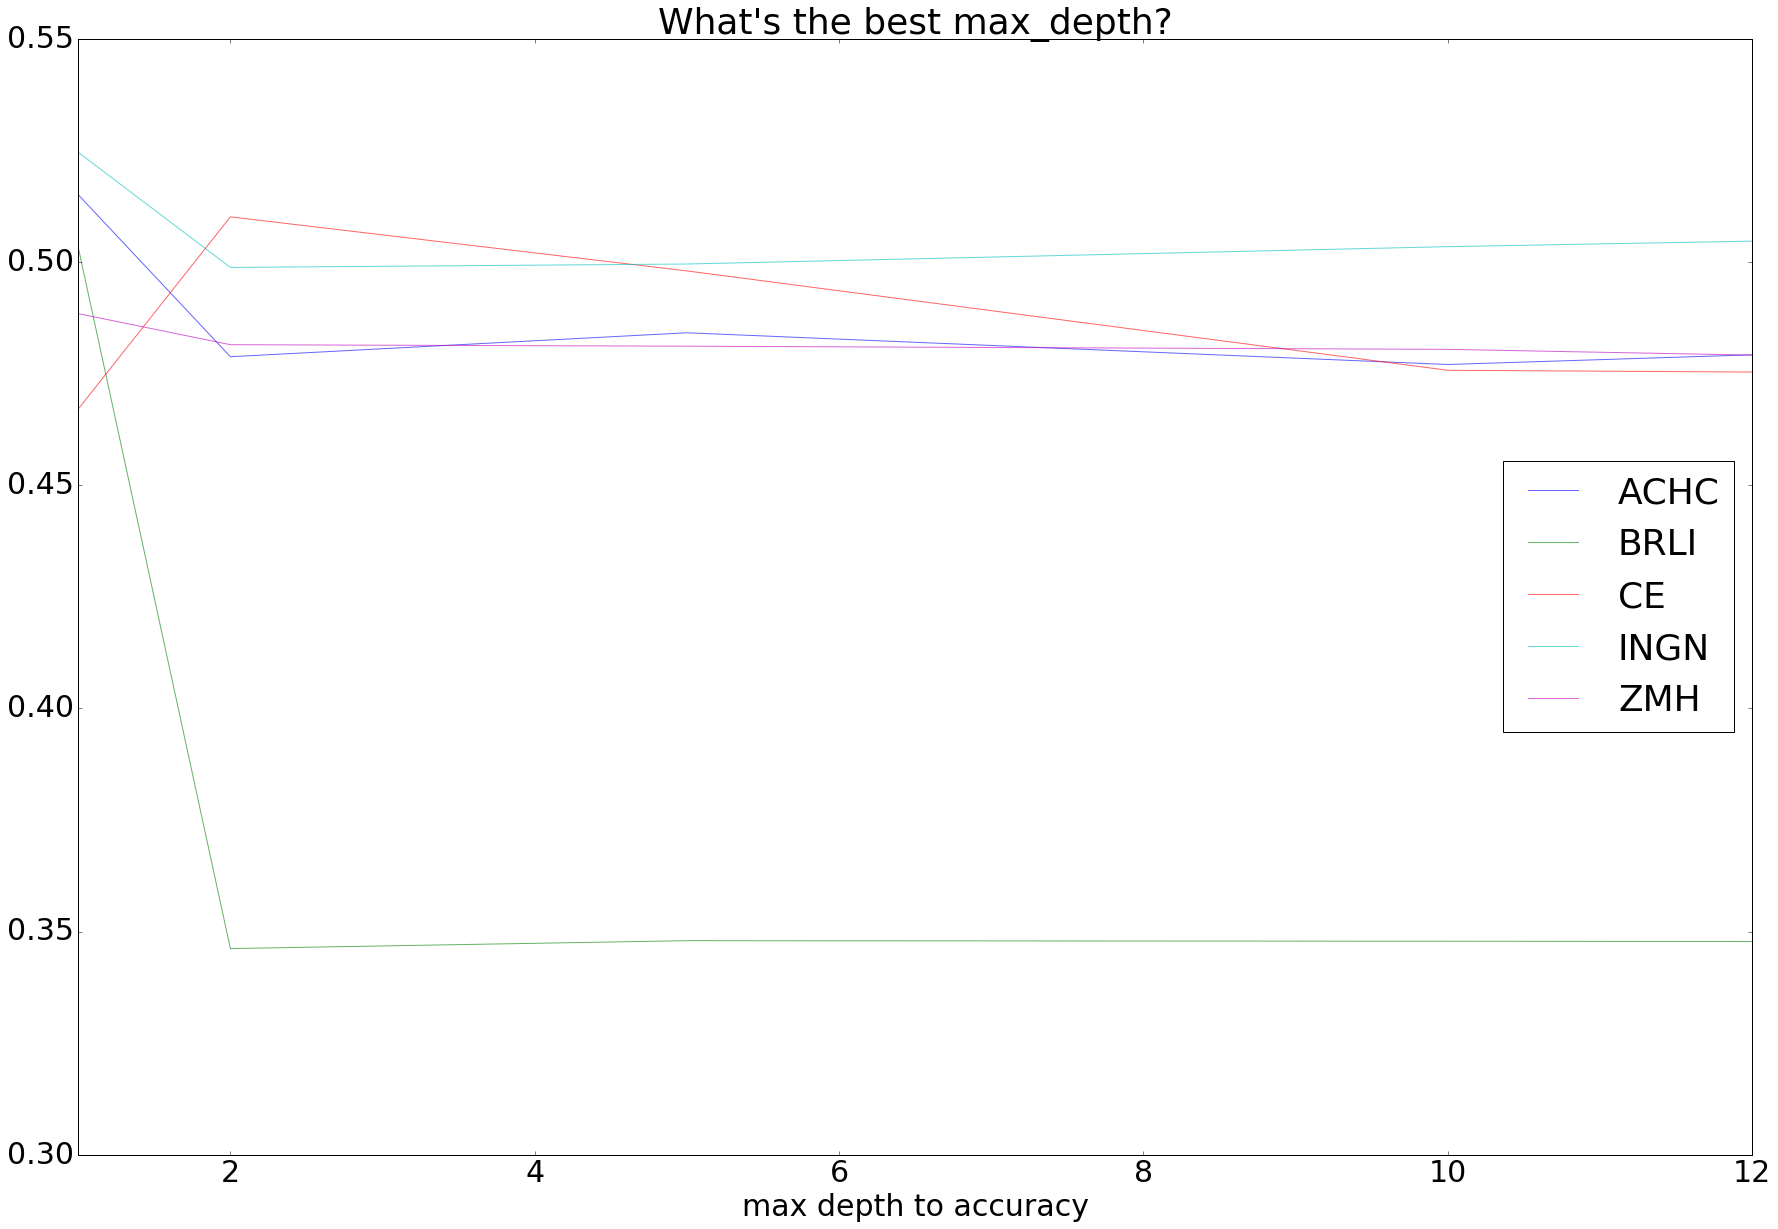

In [10]:
import numpy as np

%matplotlib inline

plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 12).groupby('max_depth').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max depth to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_depth?" )

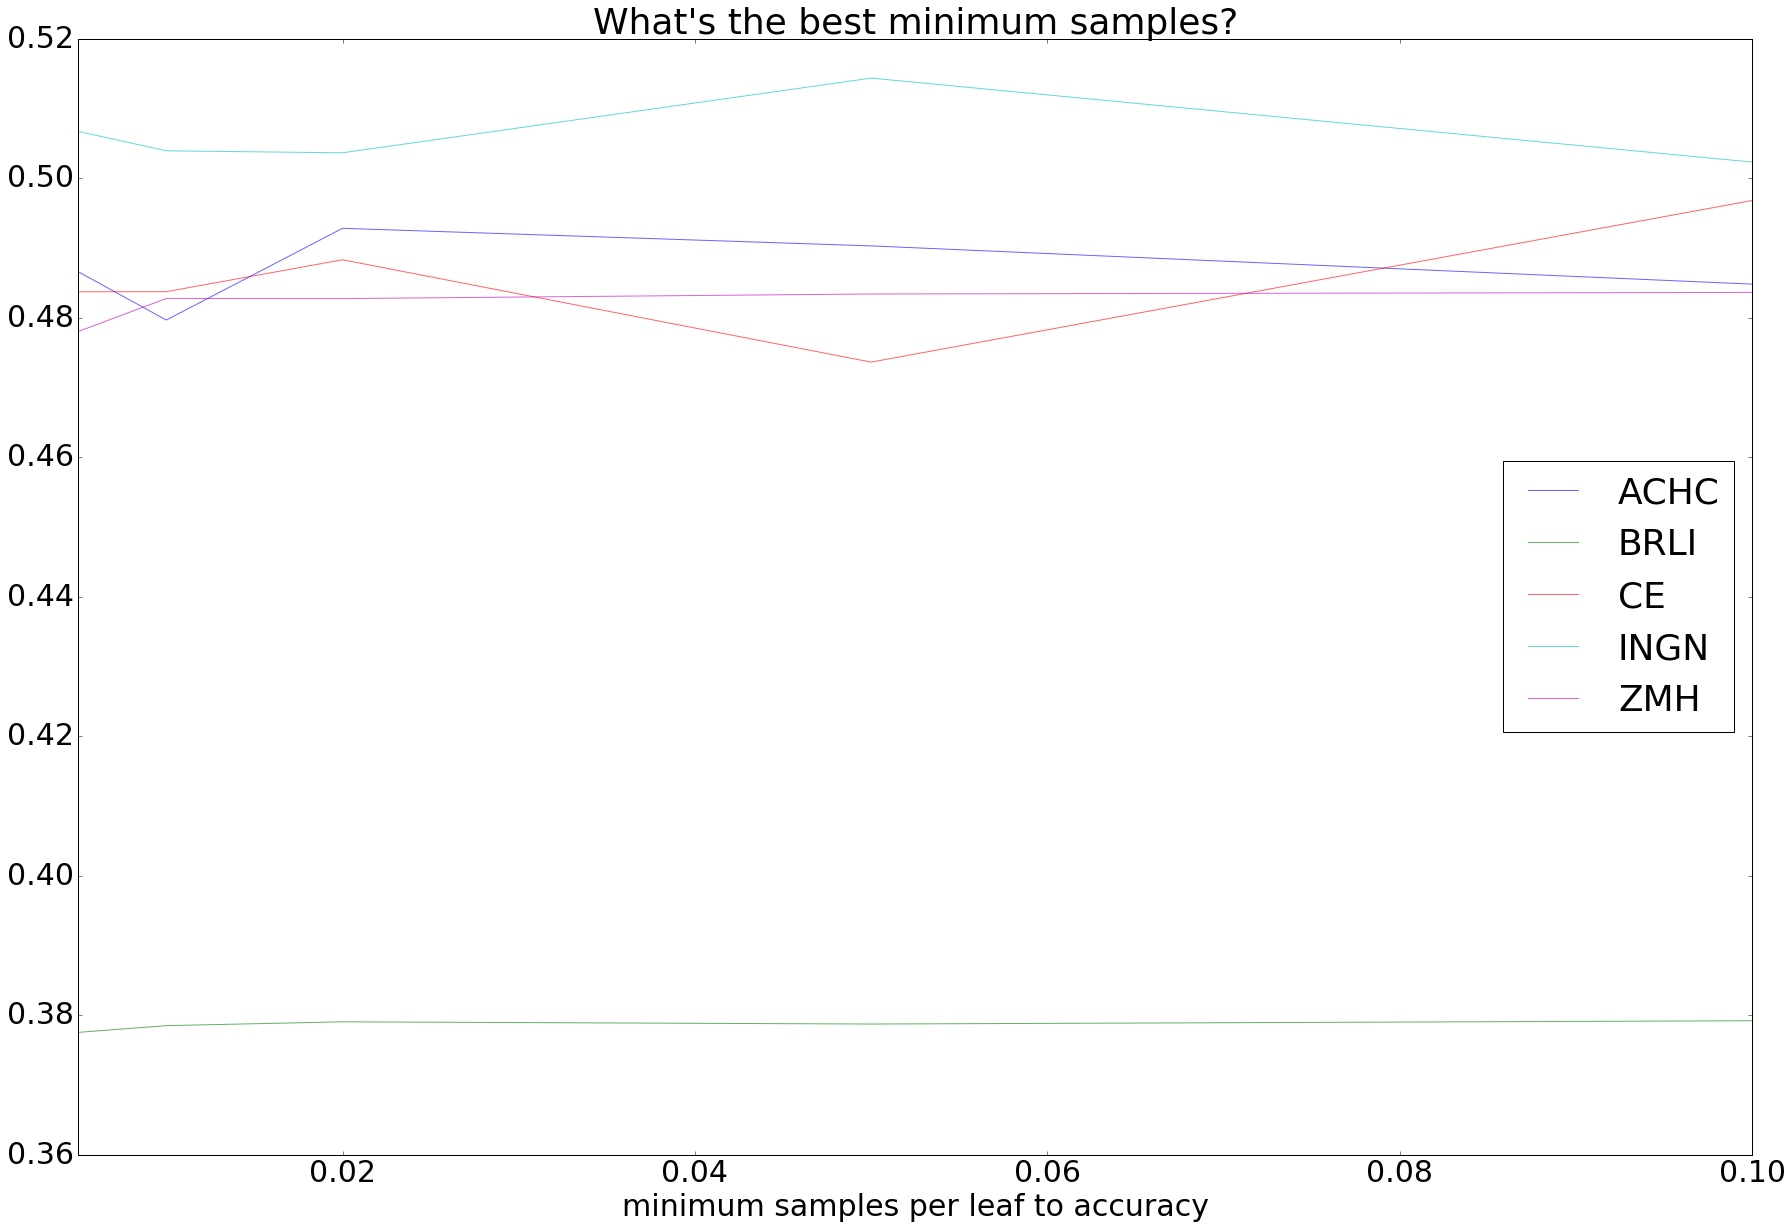

In [11]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in tresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('min_samples').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('minimum samples per leaf to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best minimum samples?" )

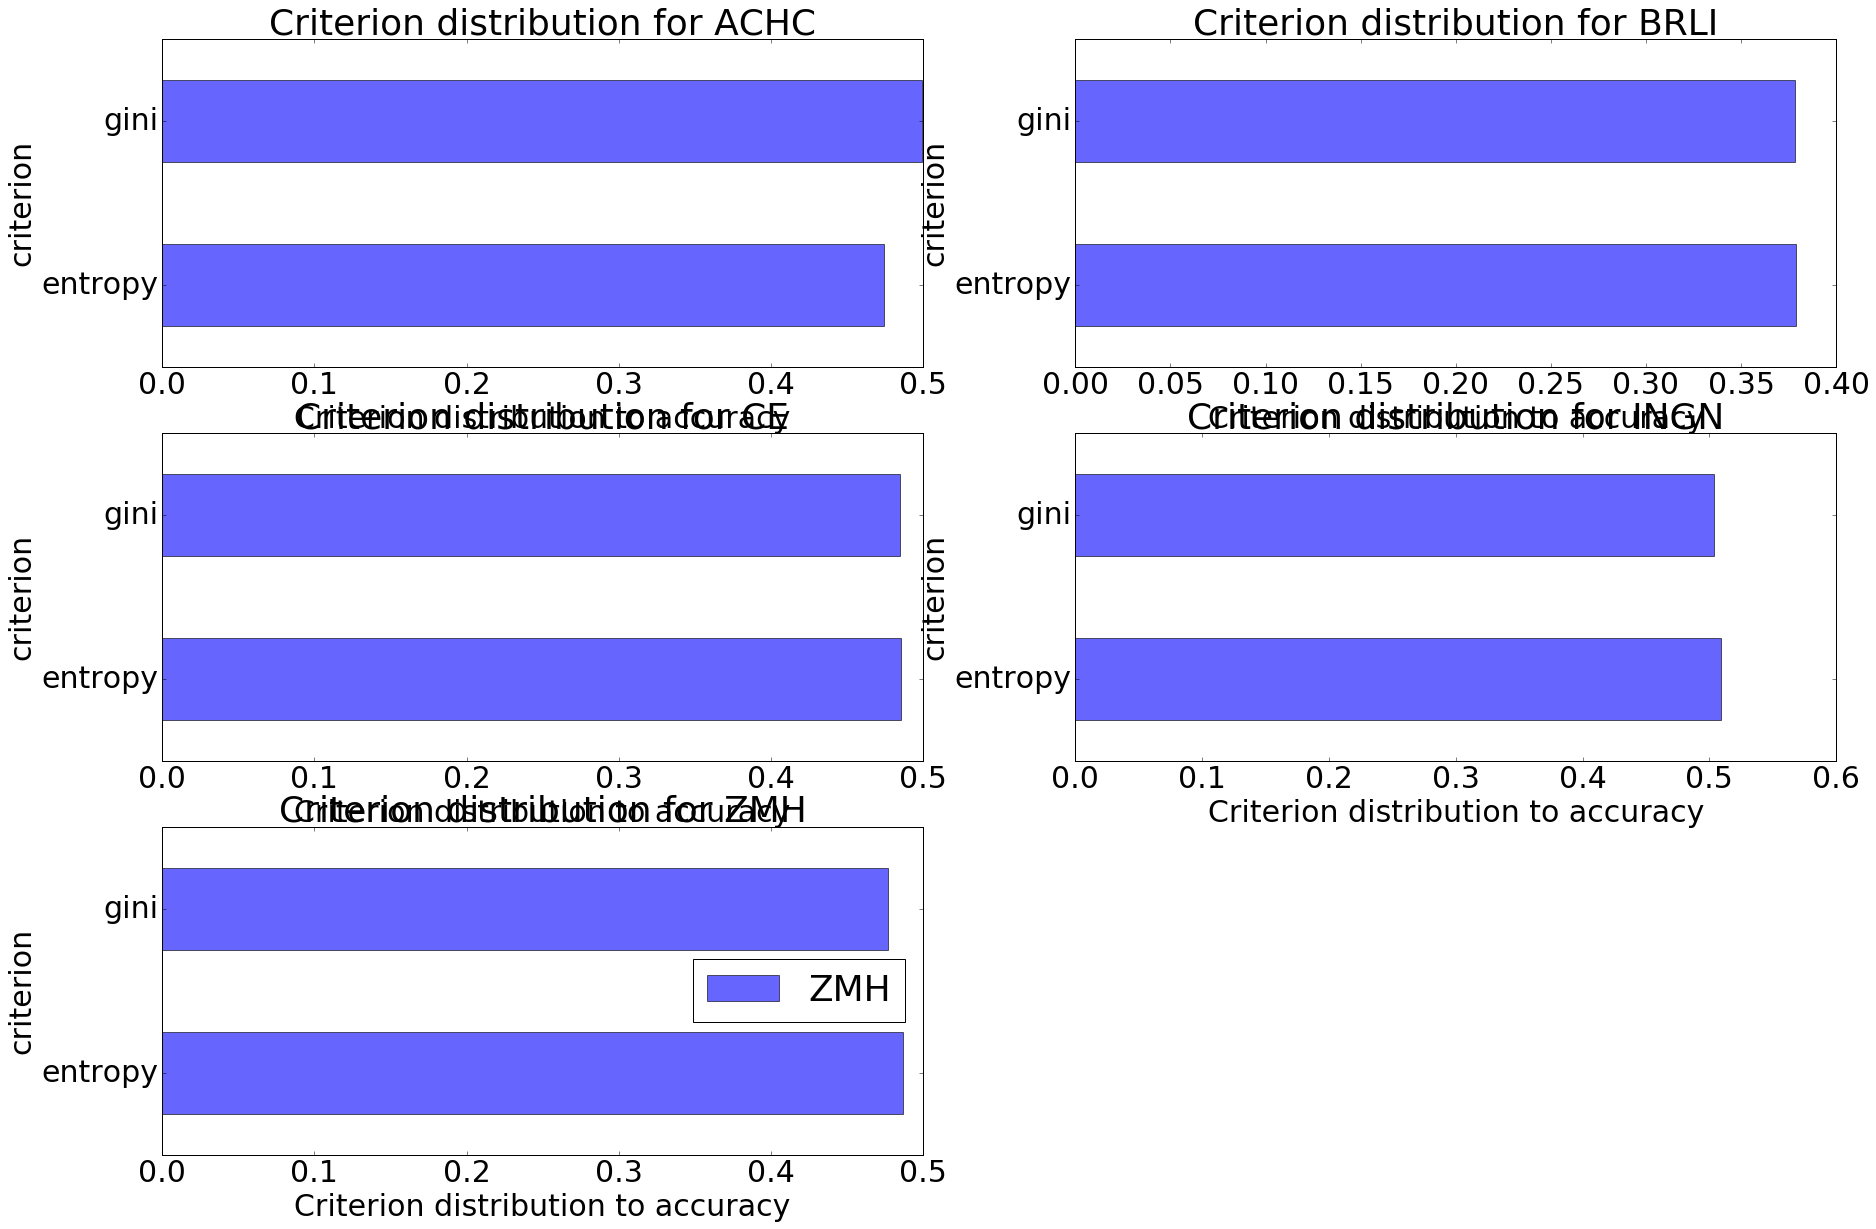

In [12]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(tresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.replace(np.nan, 1).groupby('criterion').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('Criterion distribution to accuracy')
    ax1.set_title("Criterion distribution for {}".format(name))
plt.legend(loc='best')


The best average accuracy model is:

In [13]:
print(get_best_model(tmodels, taccuracies))

(2.5154690240595761, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.01,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


which is like expected from graphs. Not good enough for AdaBoost to converge.

## SVM

We are using SVC which is a simple svm with different types of kernels.
All the data used is scaled using TrainingData. The classifier is not able to converge which is expected as out data is a mess (as it should be). The warnings are silenced for convinience.

In [14]:
from sklearn.svm import SVC
import traceback

# create iterables for all options and use itertools product
C=[0.1, 0.2, 0.5, 1.0, 2.0, 5.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
max_iter=[3, 10, 20, 100]

svm_models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    saccuracies = list(map(run_model, svm_models))

In [16]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(svm_models, saccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))

sresults = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

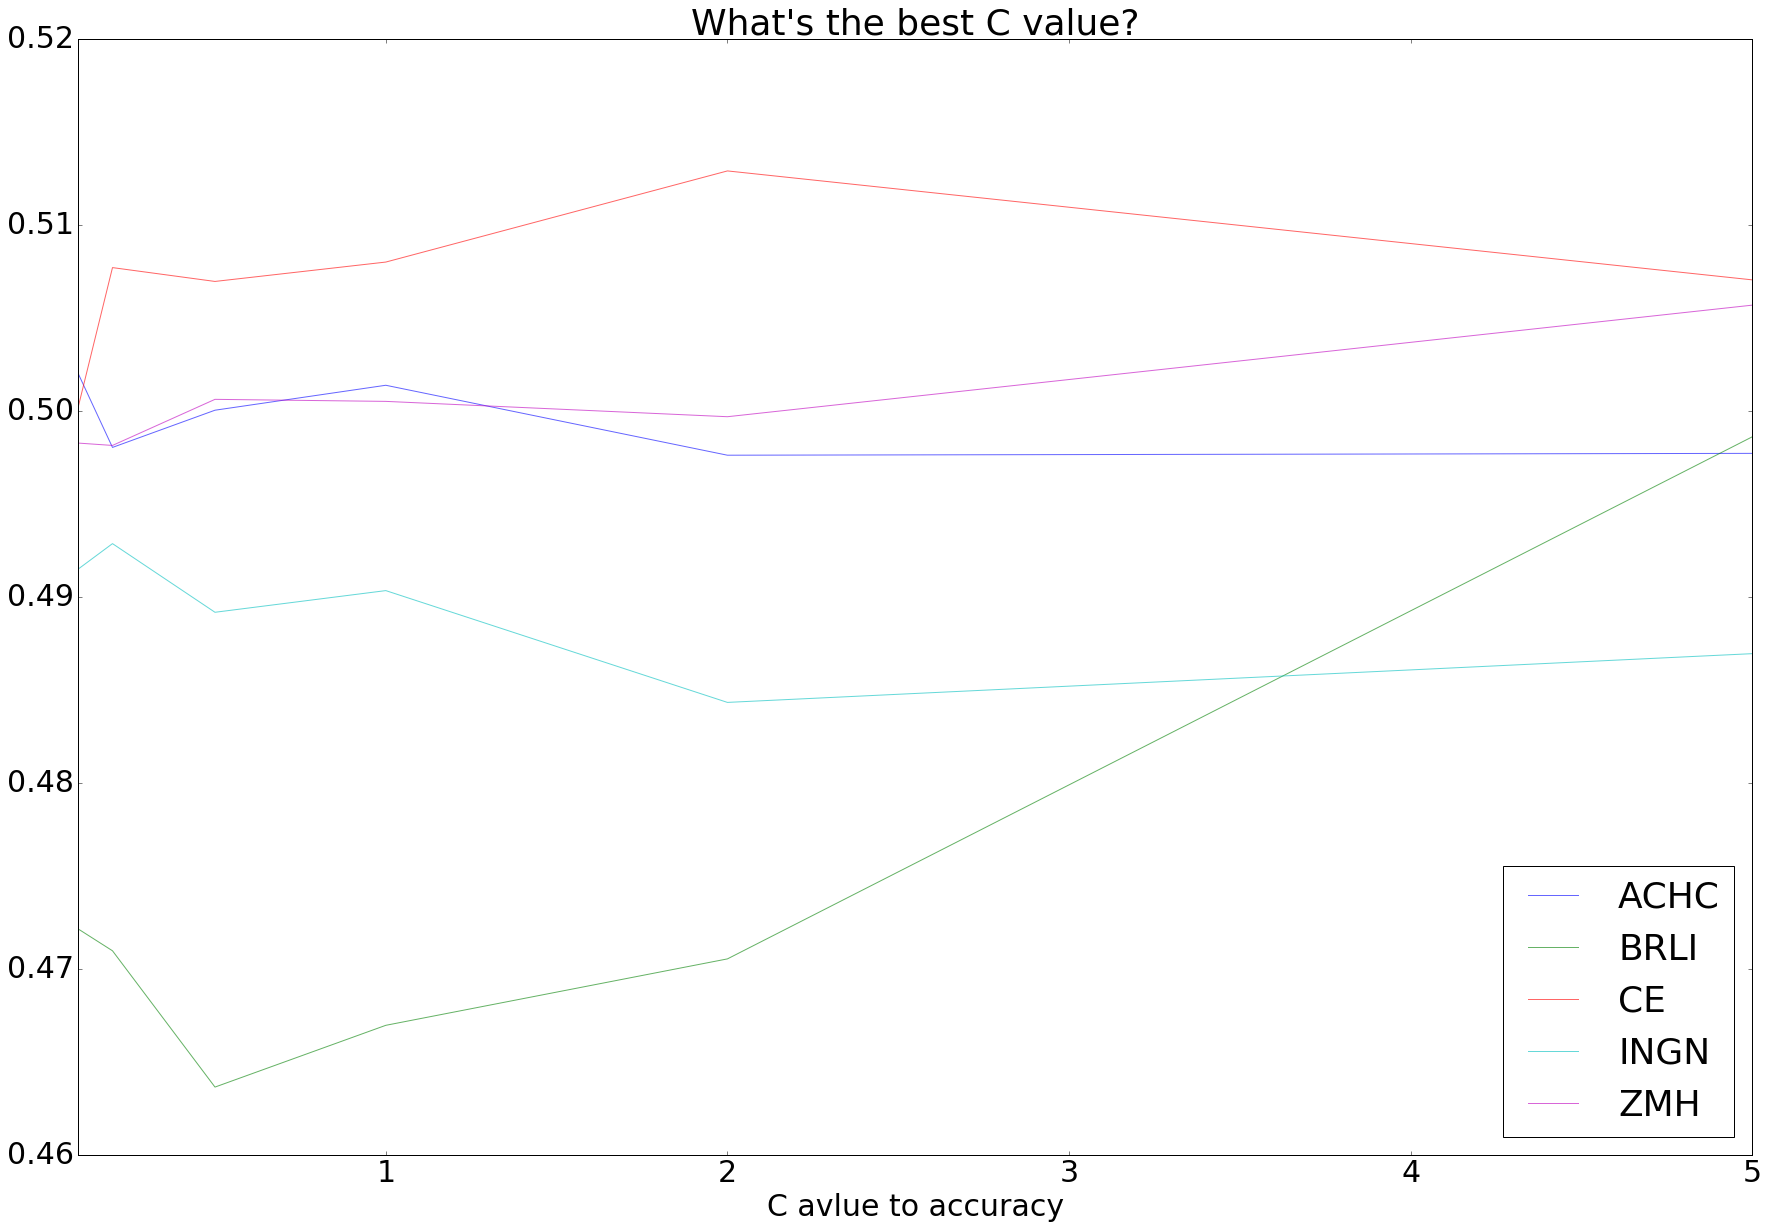

In [17]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

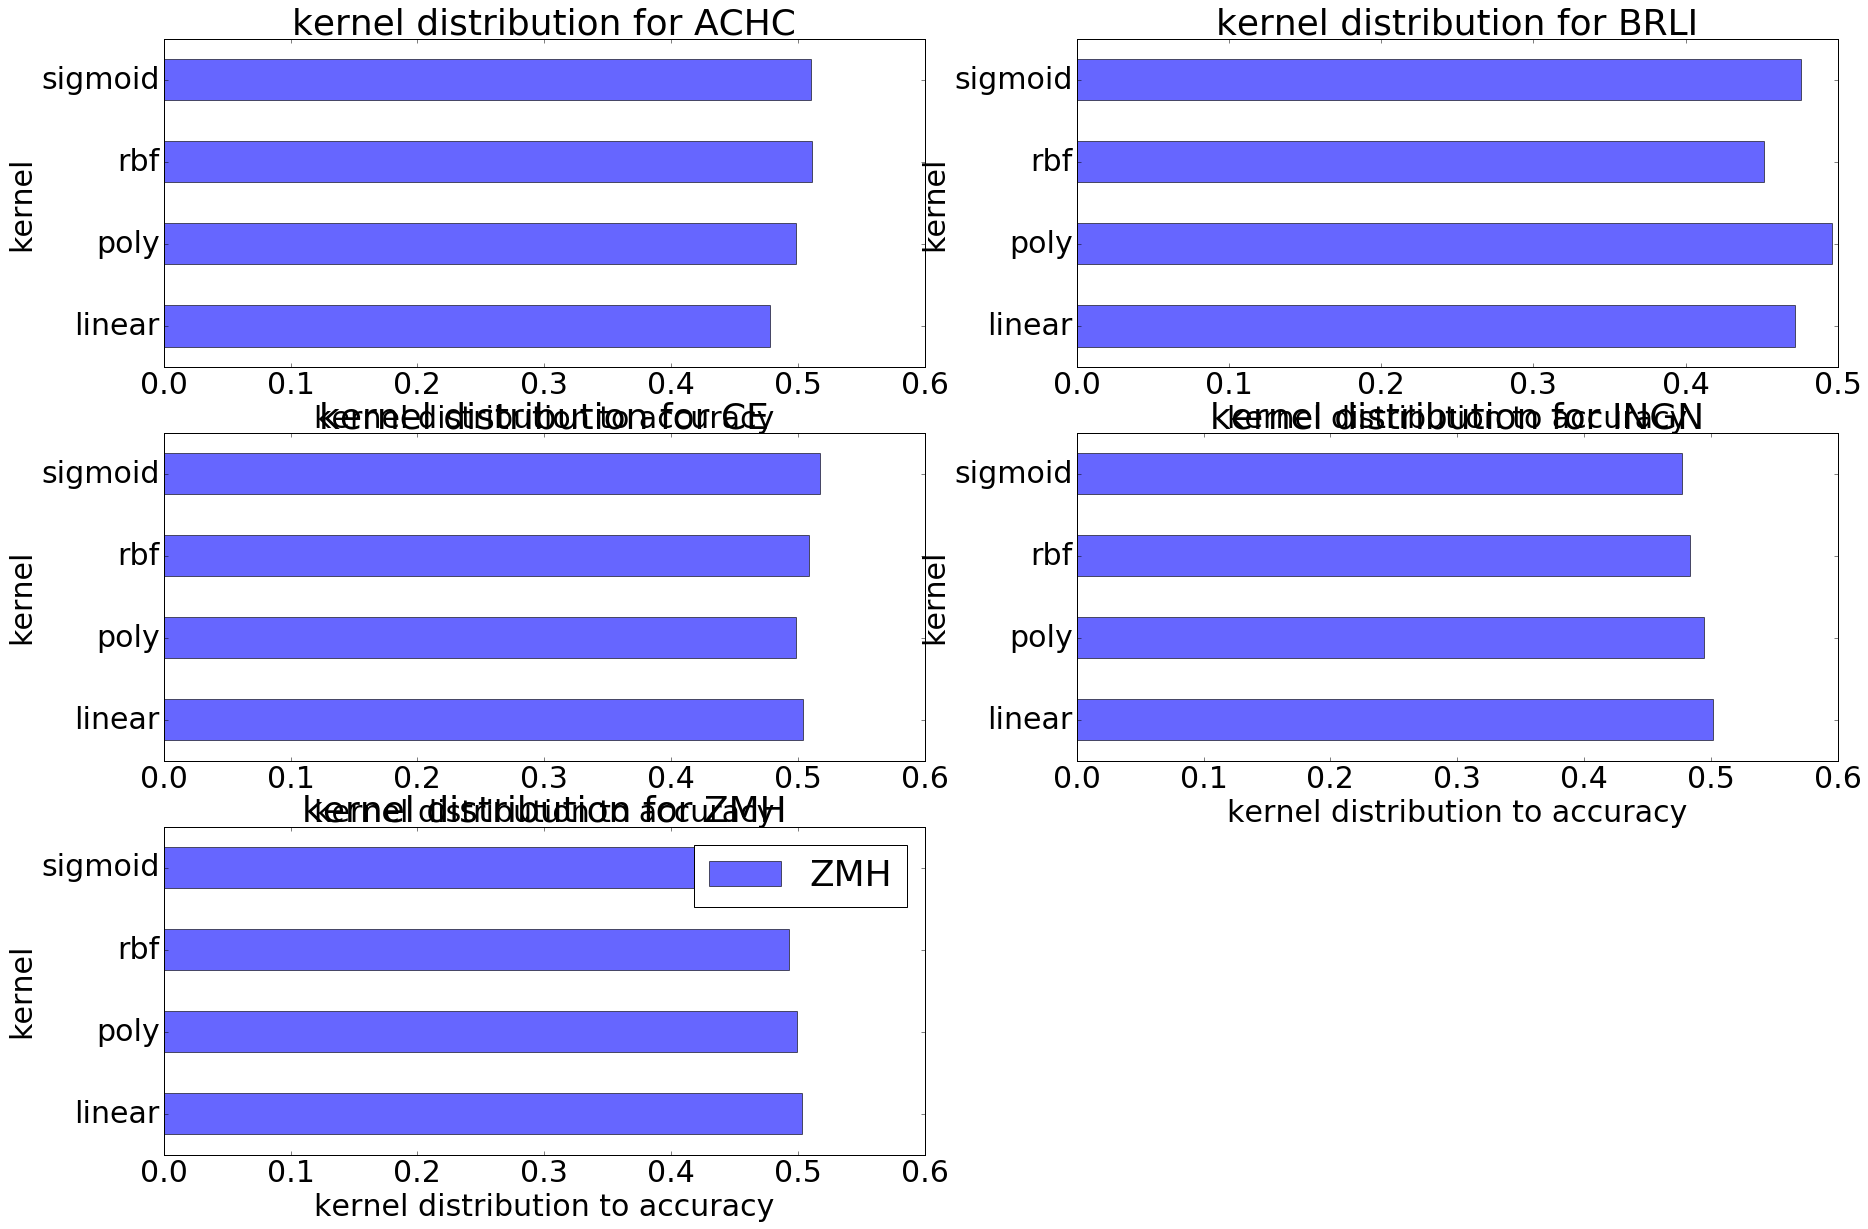

In [18]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(sresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('kernel').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('kernel distribution to accuracy')
    ax1.set_title("kernel distribution for {}".format(name))
plt.legend(loc='best')


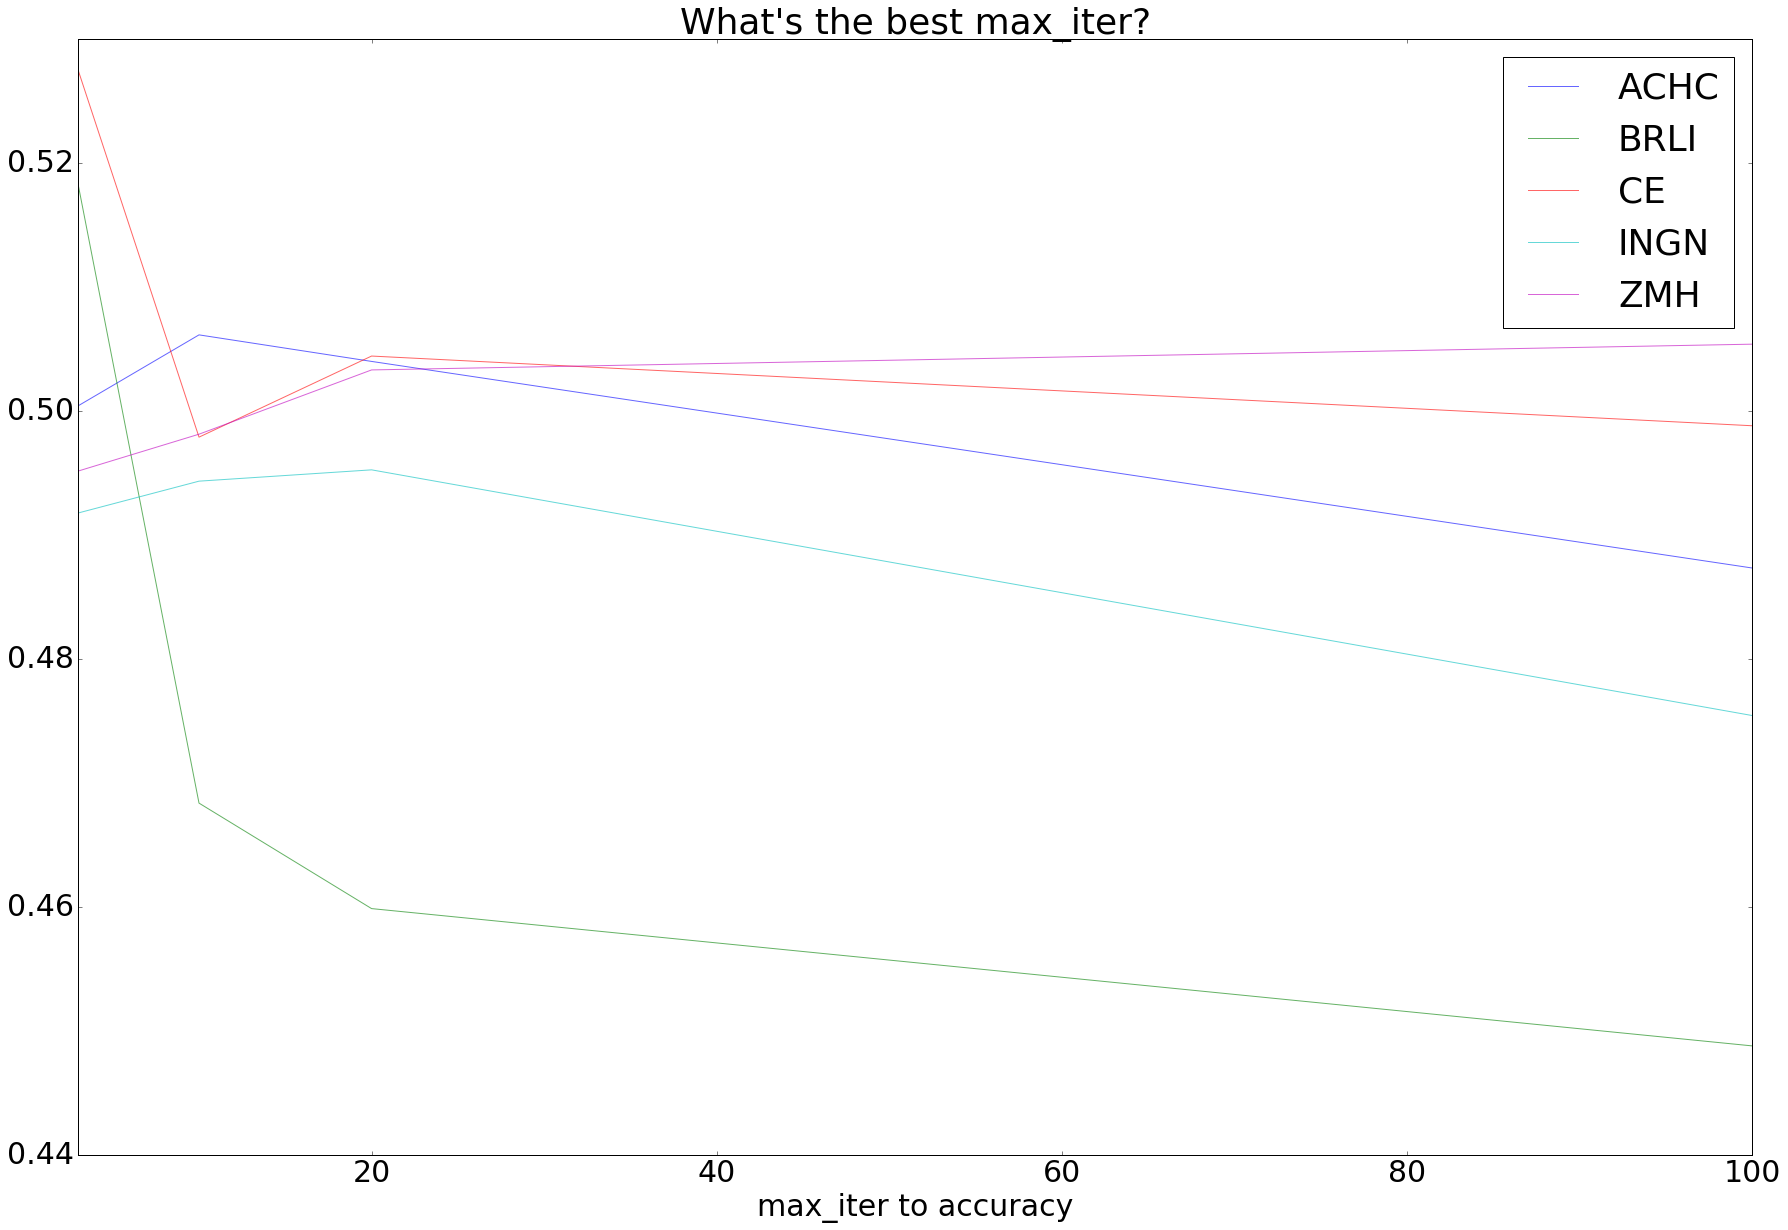

In [19]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in sresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

The best average accuracy model is:

In [20]:
print(get_best_model(svm_models, saccuracies))

(2.6348974322592165, SVC(C=5.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='sigmoid',
  max_iter=20, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


Which is mostly expected the low max iteration. It might be caused because of over fitting.
Also seems to be the best C value is not hit yet (as I would have expected given the amount of overfitting). We will try again with less parameters and more C values.
Let us check:

In [21]:
# create iterables for all options and use itertools product
C=[0.2, 5.0, 10.0, 30.0]
kernel=['linear', 'poly', 'rbf', 'sigmoid']
max_iter=[3, 20 ,100, 500]

s2models = [SVC(C=c, kernel=k, max_iter=mi) 
          for c, k, mi in product(C, kernel, max_iter)]

In [22]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    s2accuracies = list(map(run_model, s2models))

In [23]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(s2models, s2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.kernel, model.max_iter, sn, acc))

s2results = DataFrame(data, columns=('C', 'kernel', 'max_iter', 'stock', 'accuracy'))

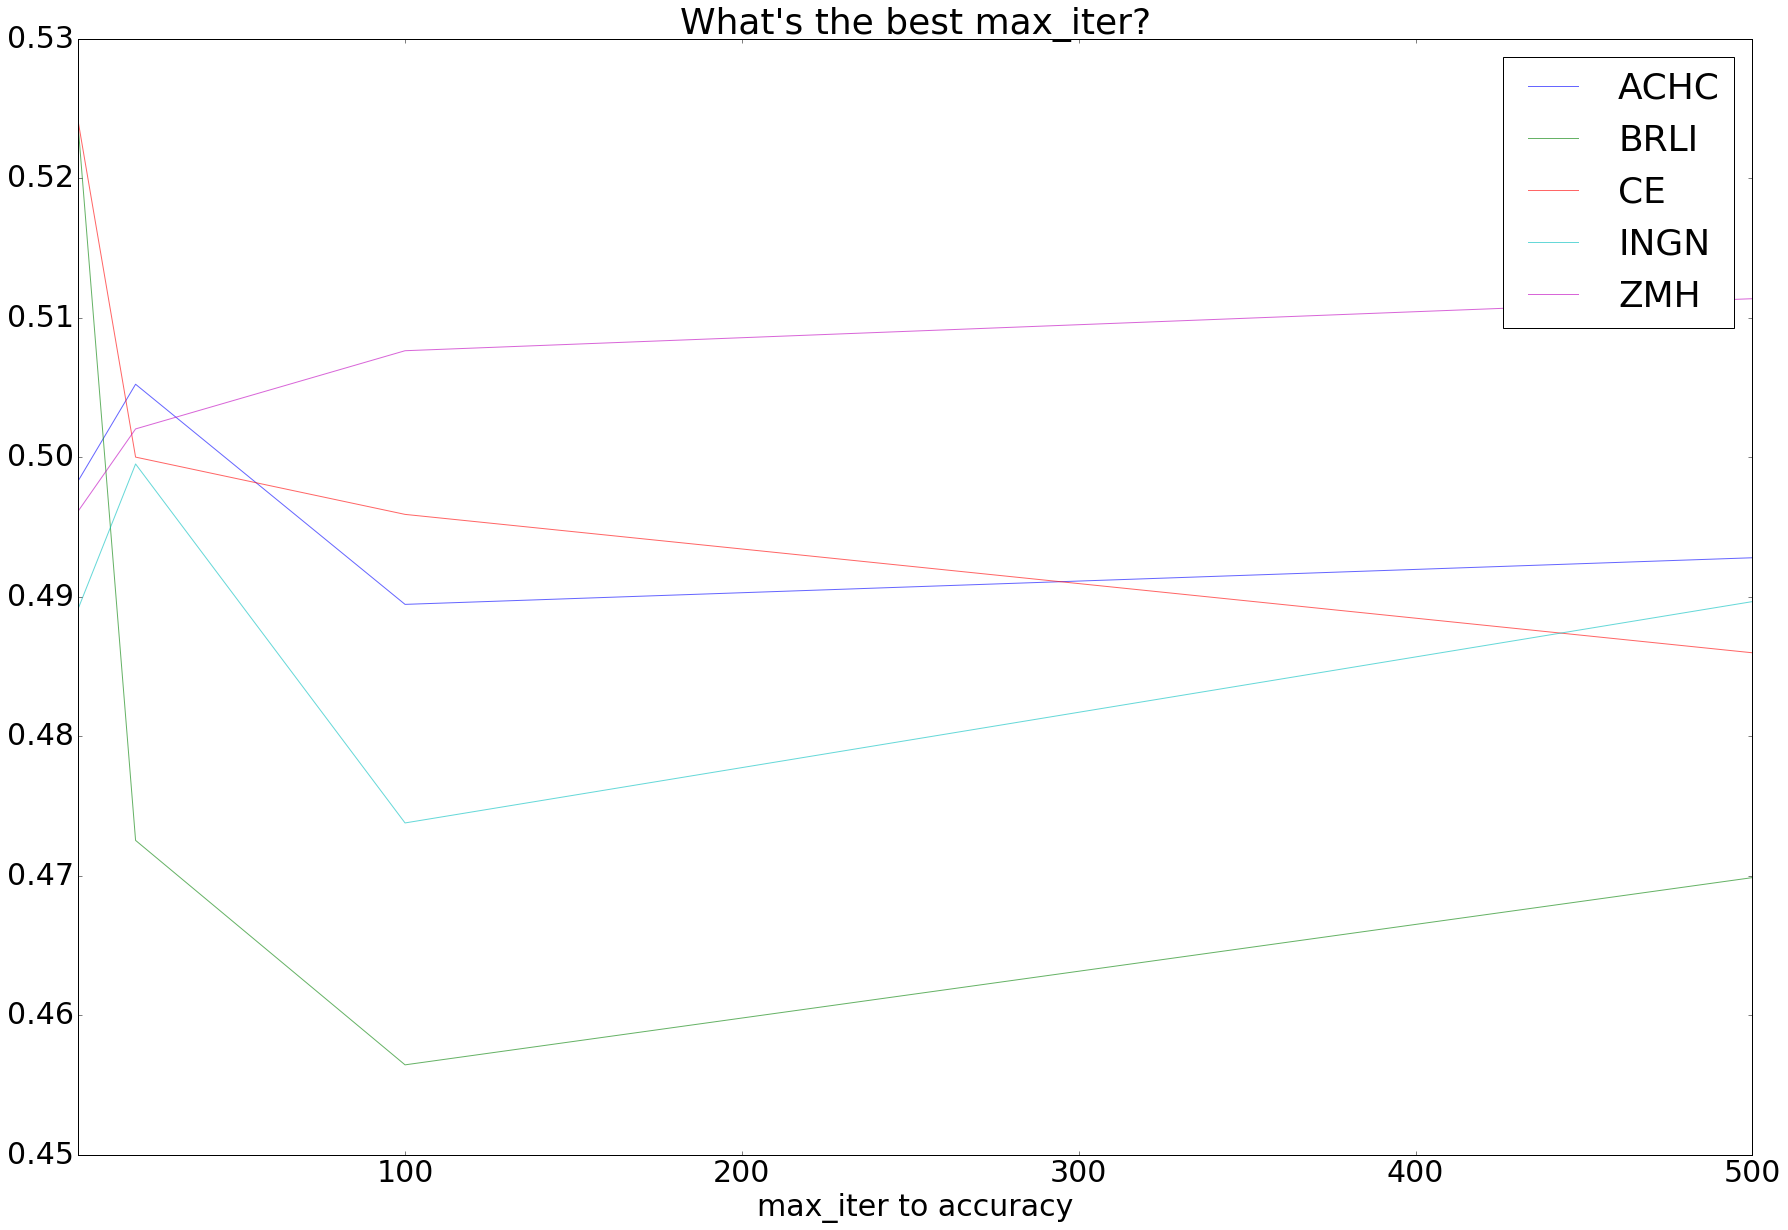

In [24]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('max_iter to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best max_iter?" )

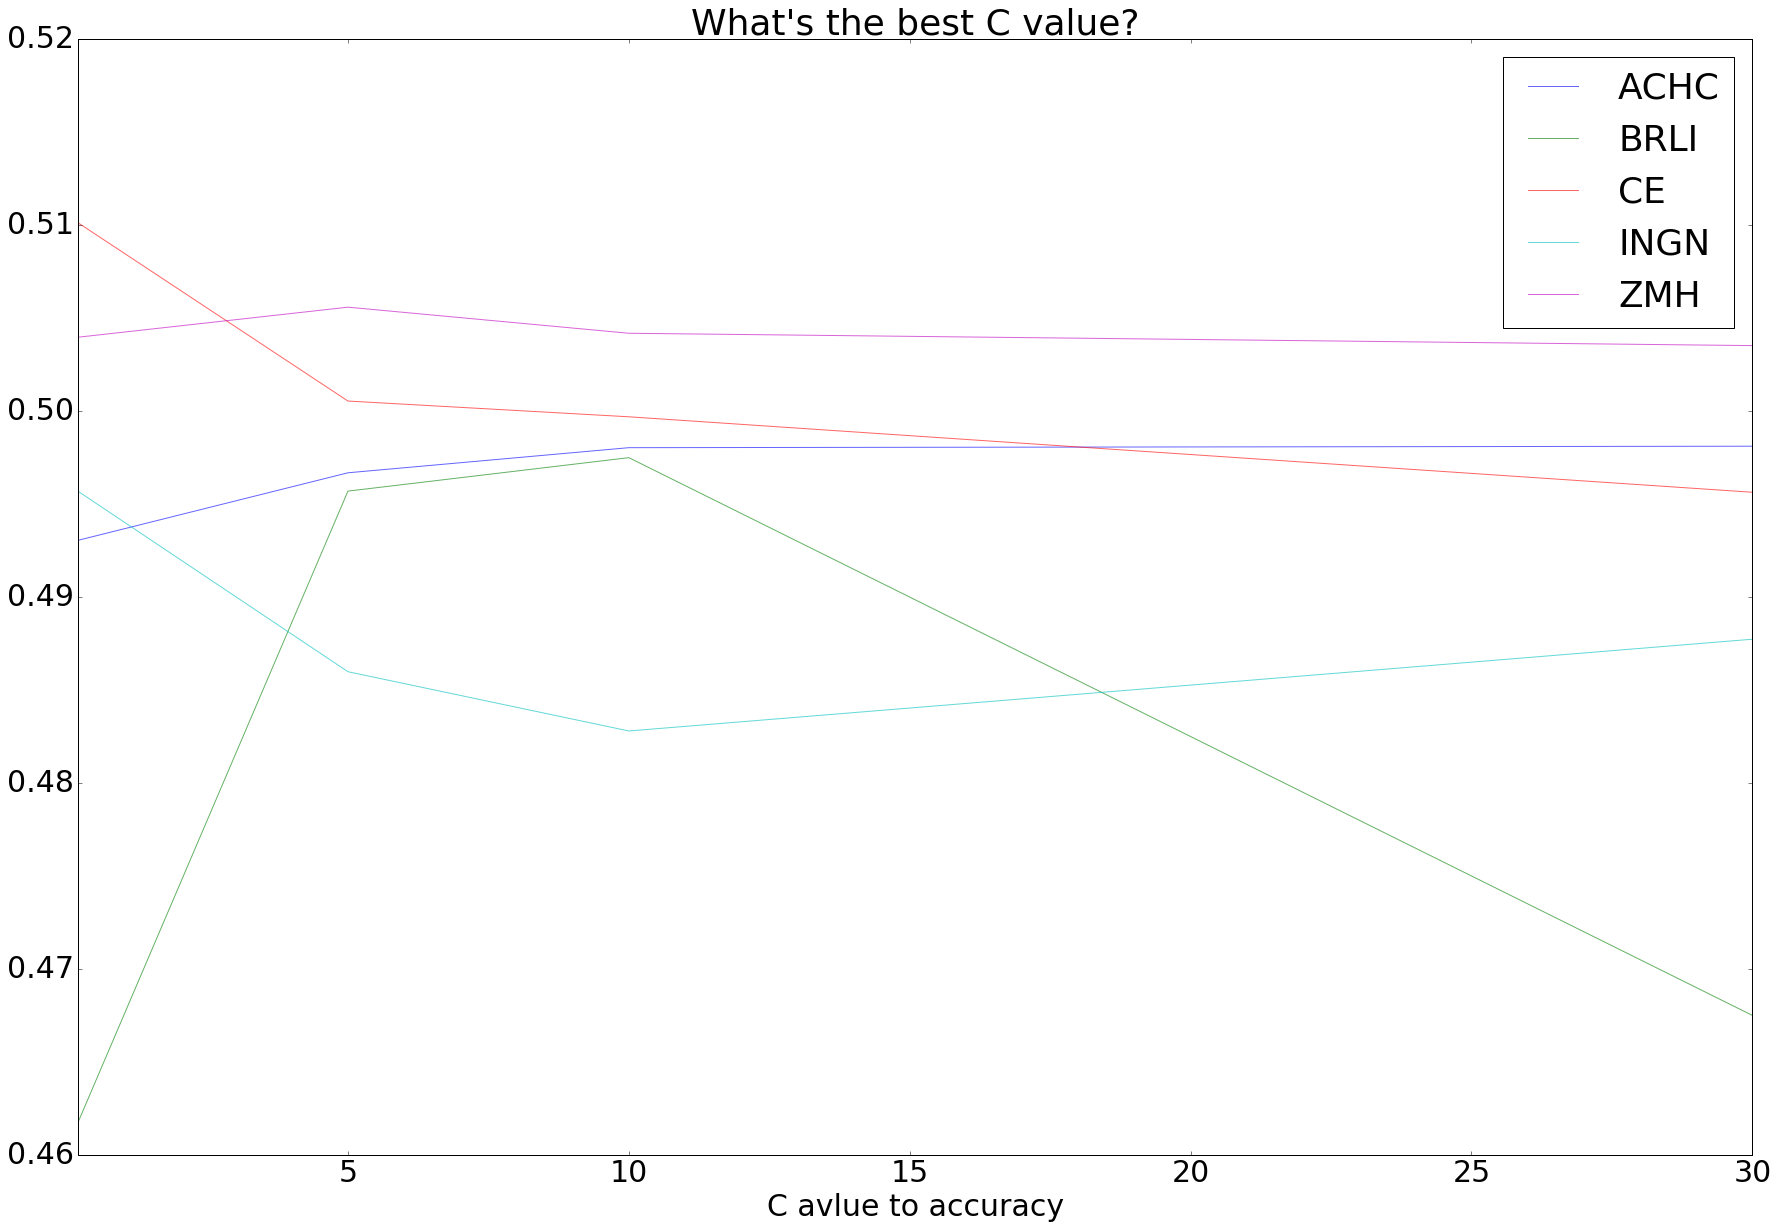

In [25]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in s2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

From checking it seems truly a lower C valuie should be chosen.
We will need to choose for C=0.1, C=2 and either way kernel=poly and max_iter=100 and consider checking a more iterations.

## Logistic Regression

This one is pretty powerful and again with data scaled should work excelently. This is expected to bring the best results. Now the two previous models were probably too weak to learn this data and this one will prevail!

We will look at penalty function (norm), regularization strength (C param), intercept_scaling (the constant added to class calc, should play with this a little), max_iter and tol (tolerance for stopping).

In [26]:
from sklearn.linear_model import LogisticRegression

# create iterables for all options and use itertools product
penaltys = ['l1', 'l2']
Cs = [0.5, 0.7, 1.0, 1.3, 1.5]
intercept_scalings = [0.5, 0.7, 1.0, 1.3, 1.5]
max_iters = [3, 10, 20, 100]
tols = [0.00007, 0.0001, 0.0005]

lmodels = [LogisticRegression(C=c, penalty=p, intercept_scaling=isc, max_iter=mi, tol=t) 
          for c, p, isc, mi, t in product(Cs, penaltys, intercept_scalings, max_iters, tols)]

In [27]:
laccuracies = list(map(run_model, lmodels))

In [28]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(lmodels, laccuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.penalty, model.intercept_scaling, model.max_iter, model.tol, sn, acc))

lresults = DataFrame(data, columns=('C', 'penalty', 'intercept_scaling', 'max_iter', 'tol', 'stock', 'accuracy'))

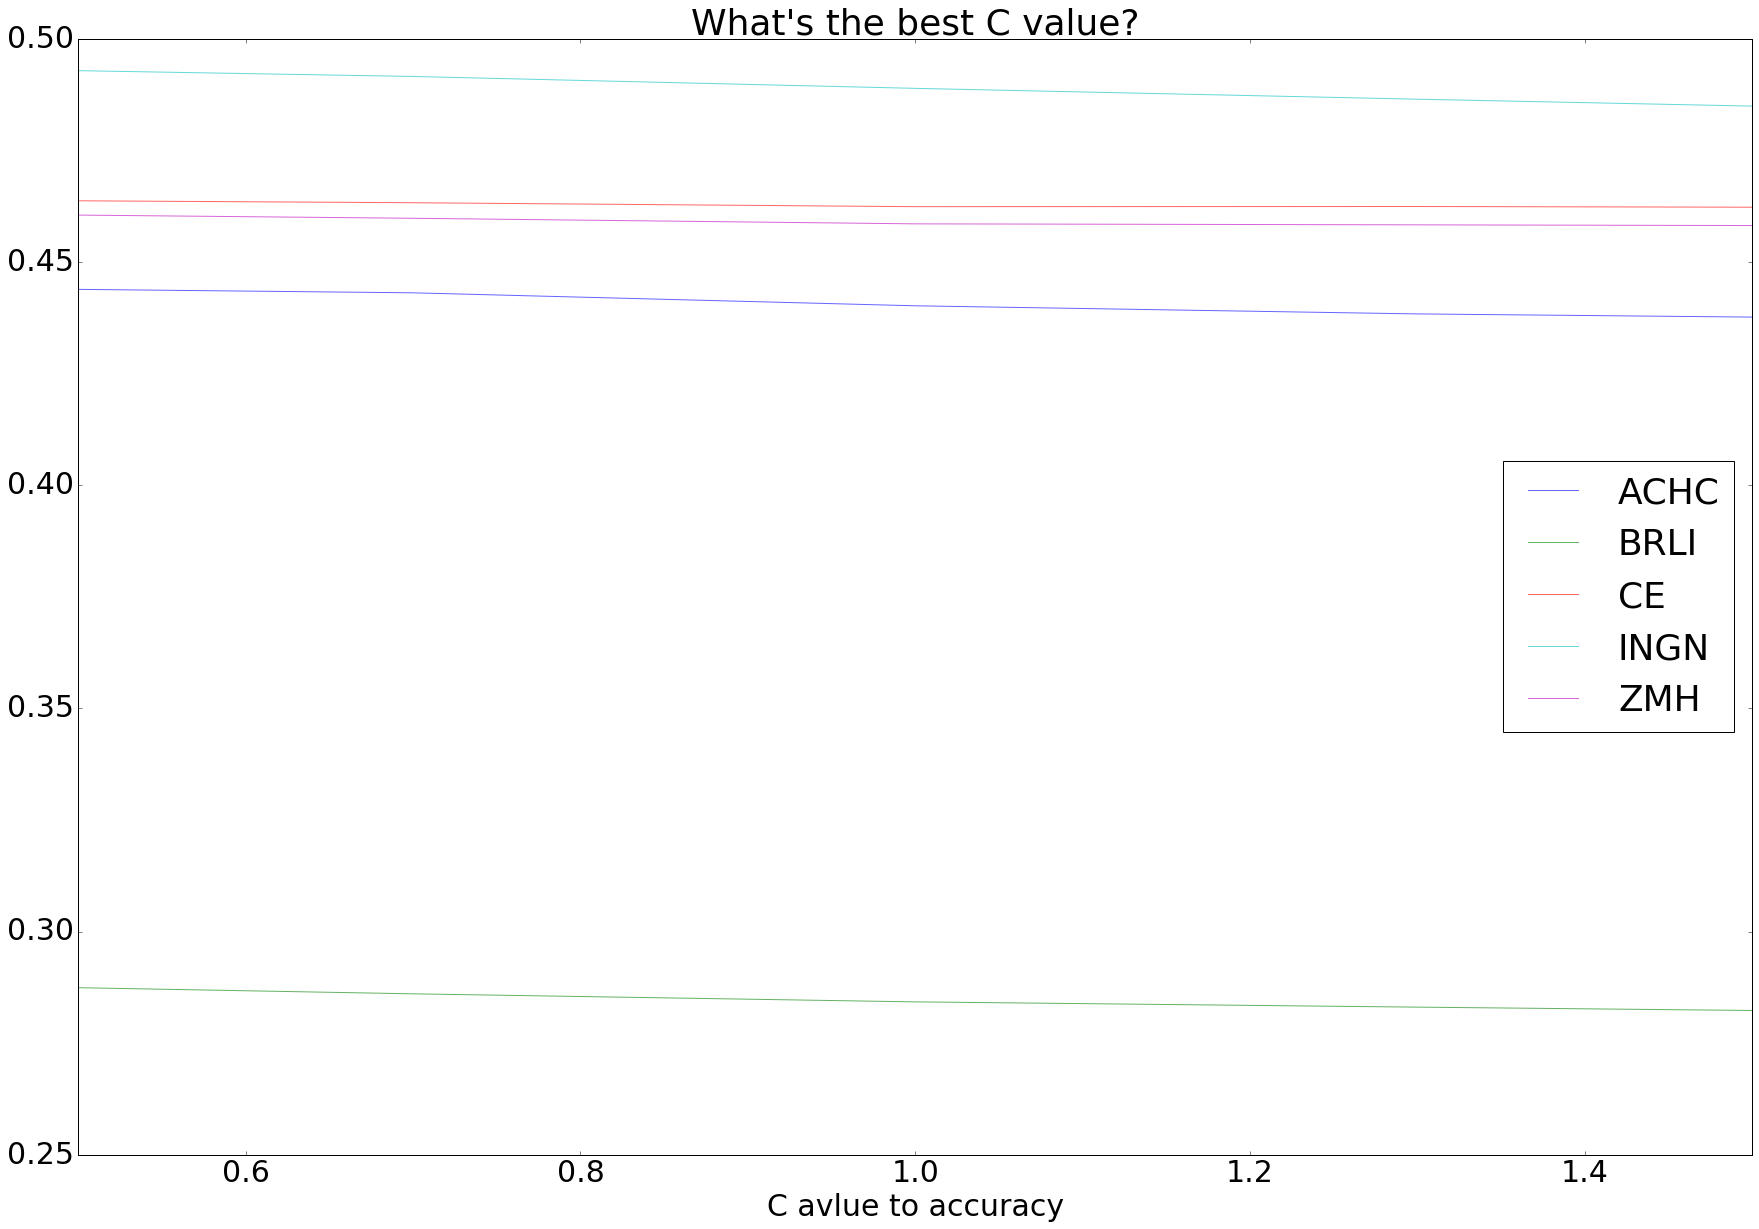

In [29]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

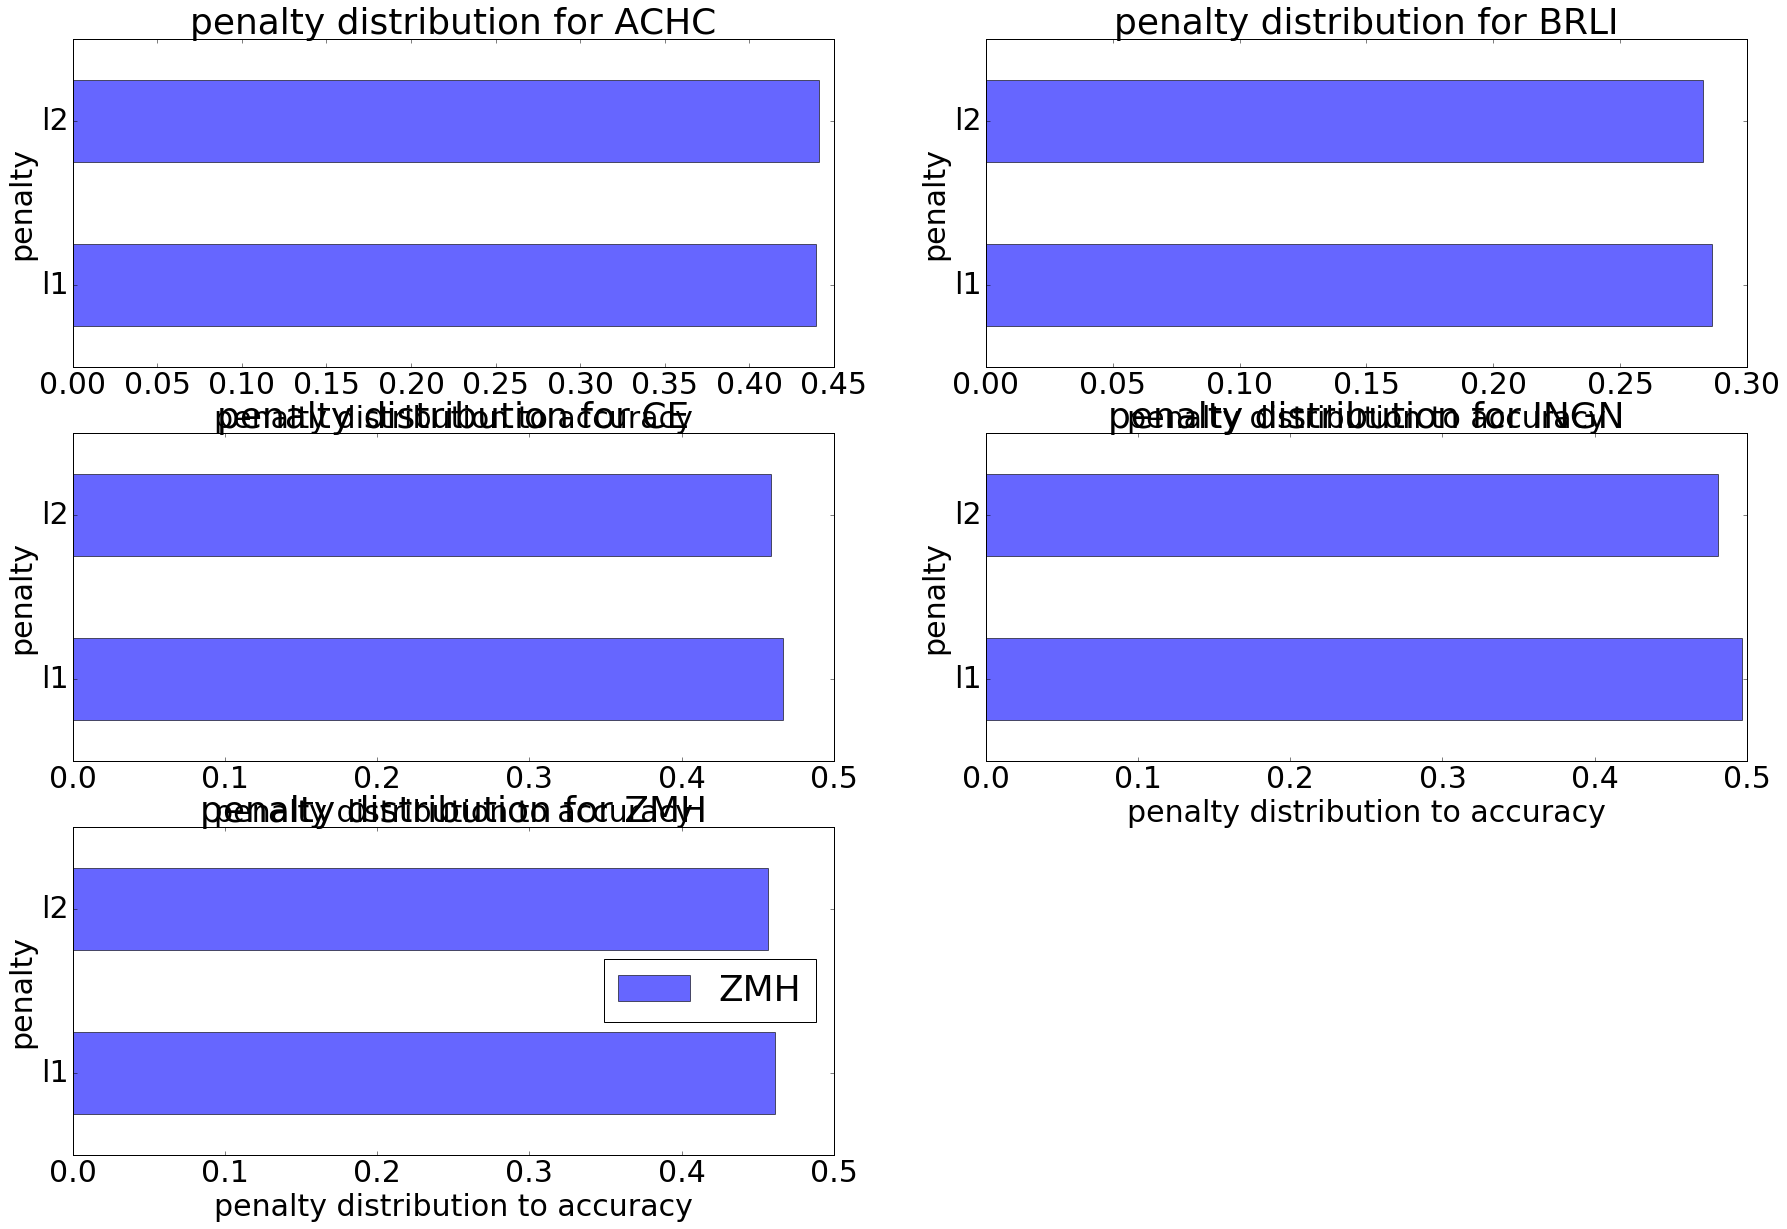

In [30]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

locations = [(0,0), (0,1), (1,0), (1,1), (2,0), (2,1)]

for i, (name, group) in enumerate(lresults.groupby('stock')):
    ax1 = plt.subplot2grid((3,2), locations[i])
    # since we are counting values it makes sense to regularize the counts
    group.groupby('penalty').agg('mean')['accuracy'].plot(kind='barh', label=name, alpha=alpha)
    ax1.set_xlabel('penalty distribution to accuracy')
    ax1.set_title("penalty distribution for {}".format(name))
plt.legend(loc='best')


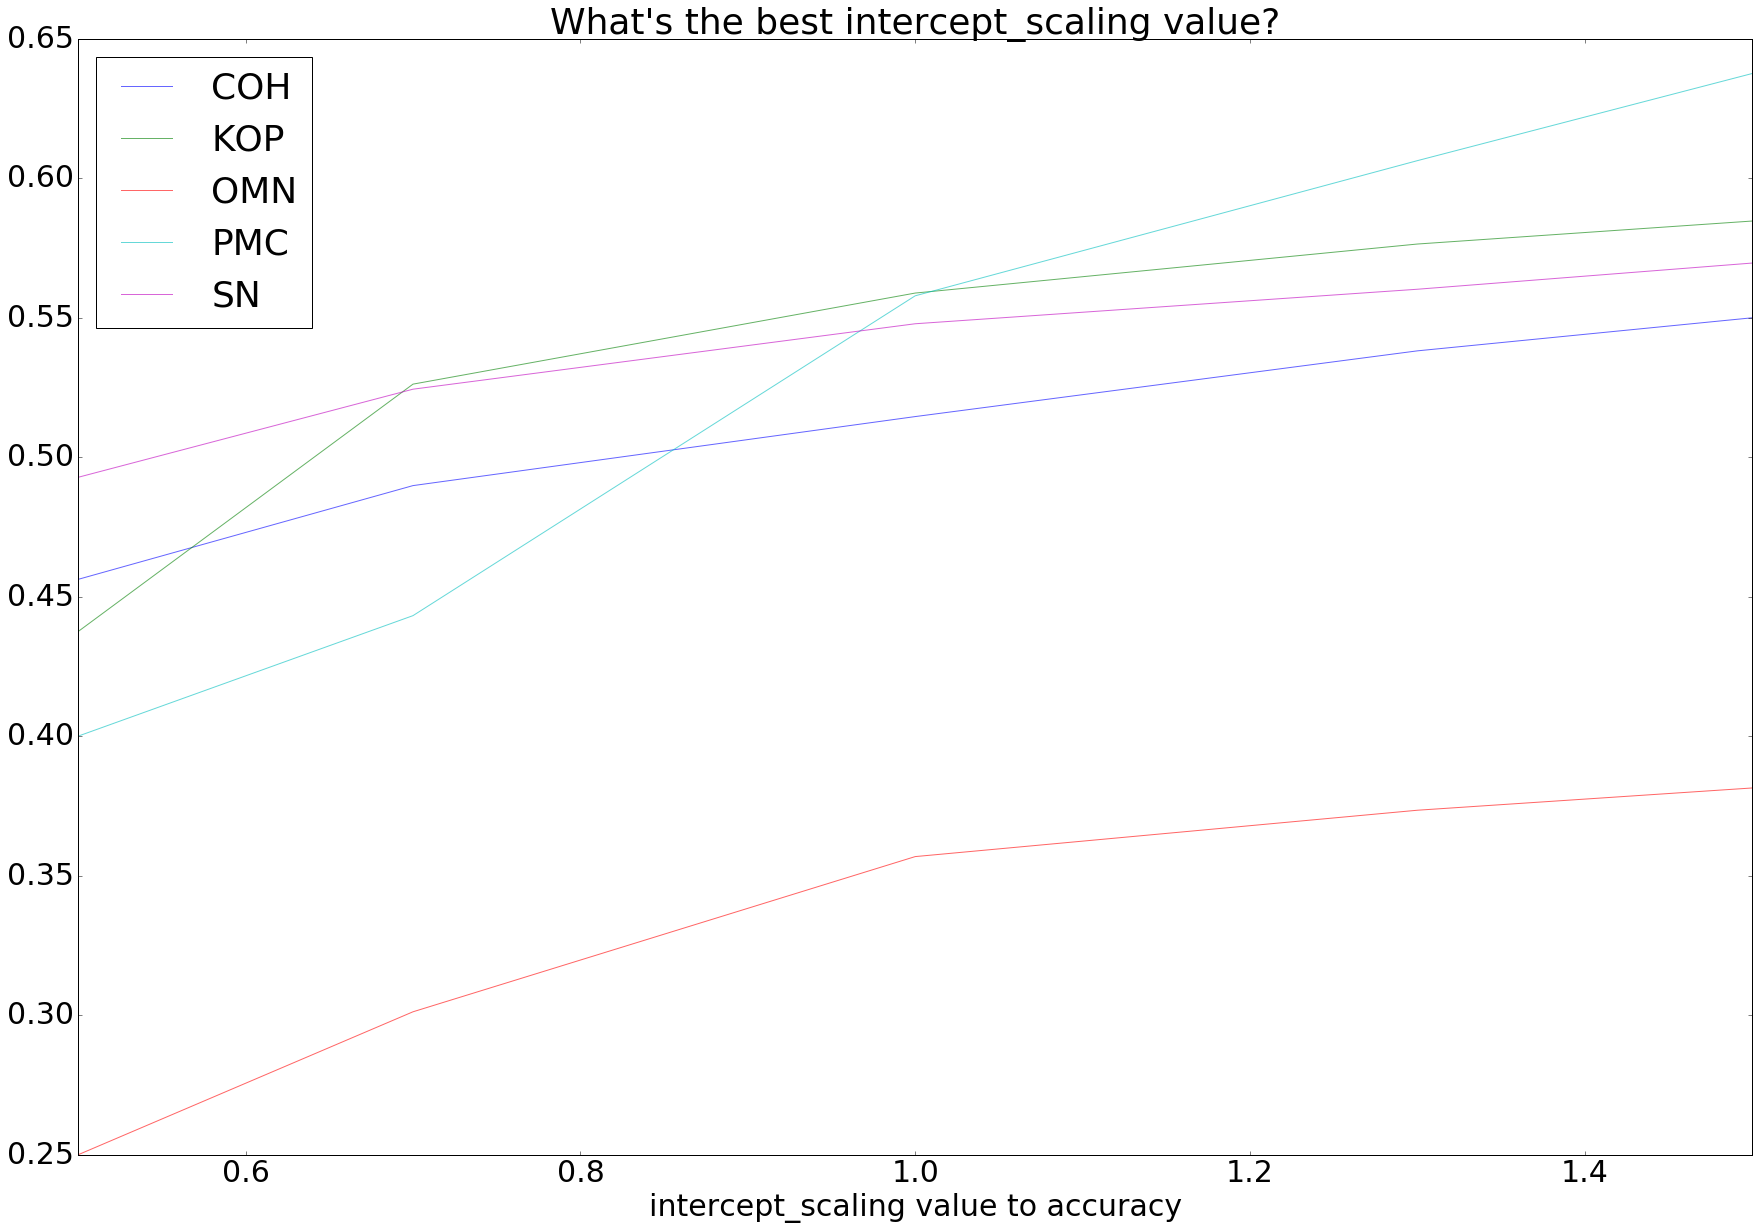

In [41]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value tso accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

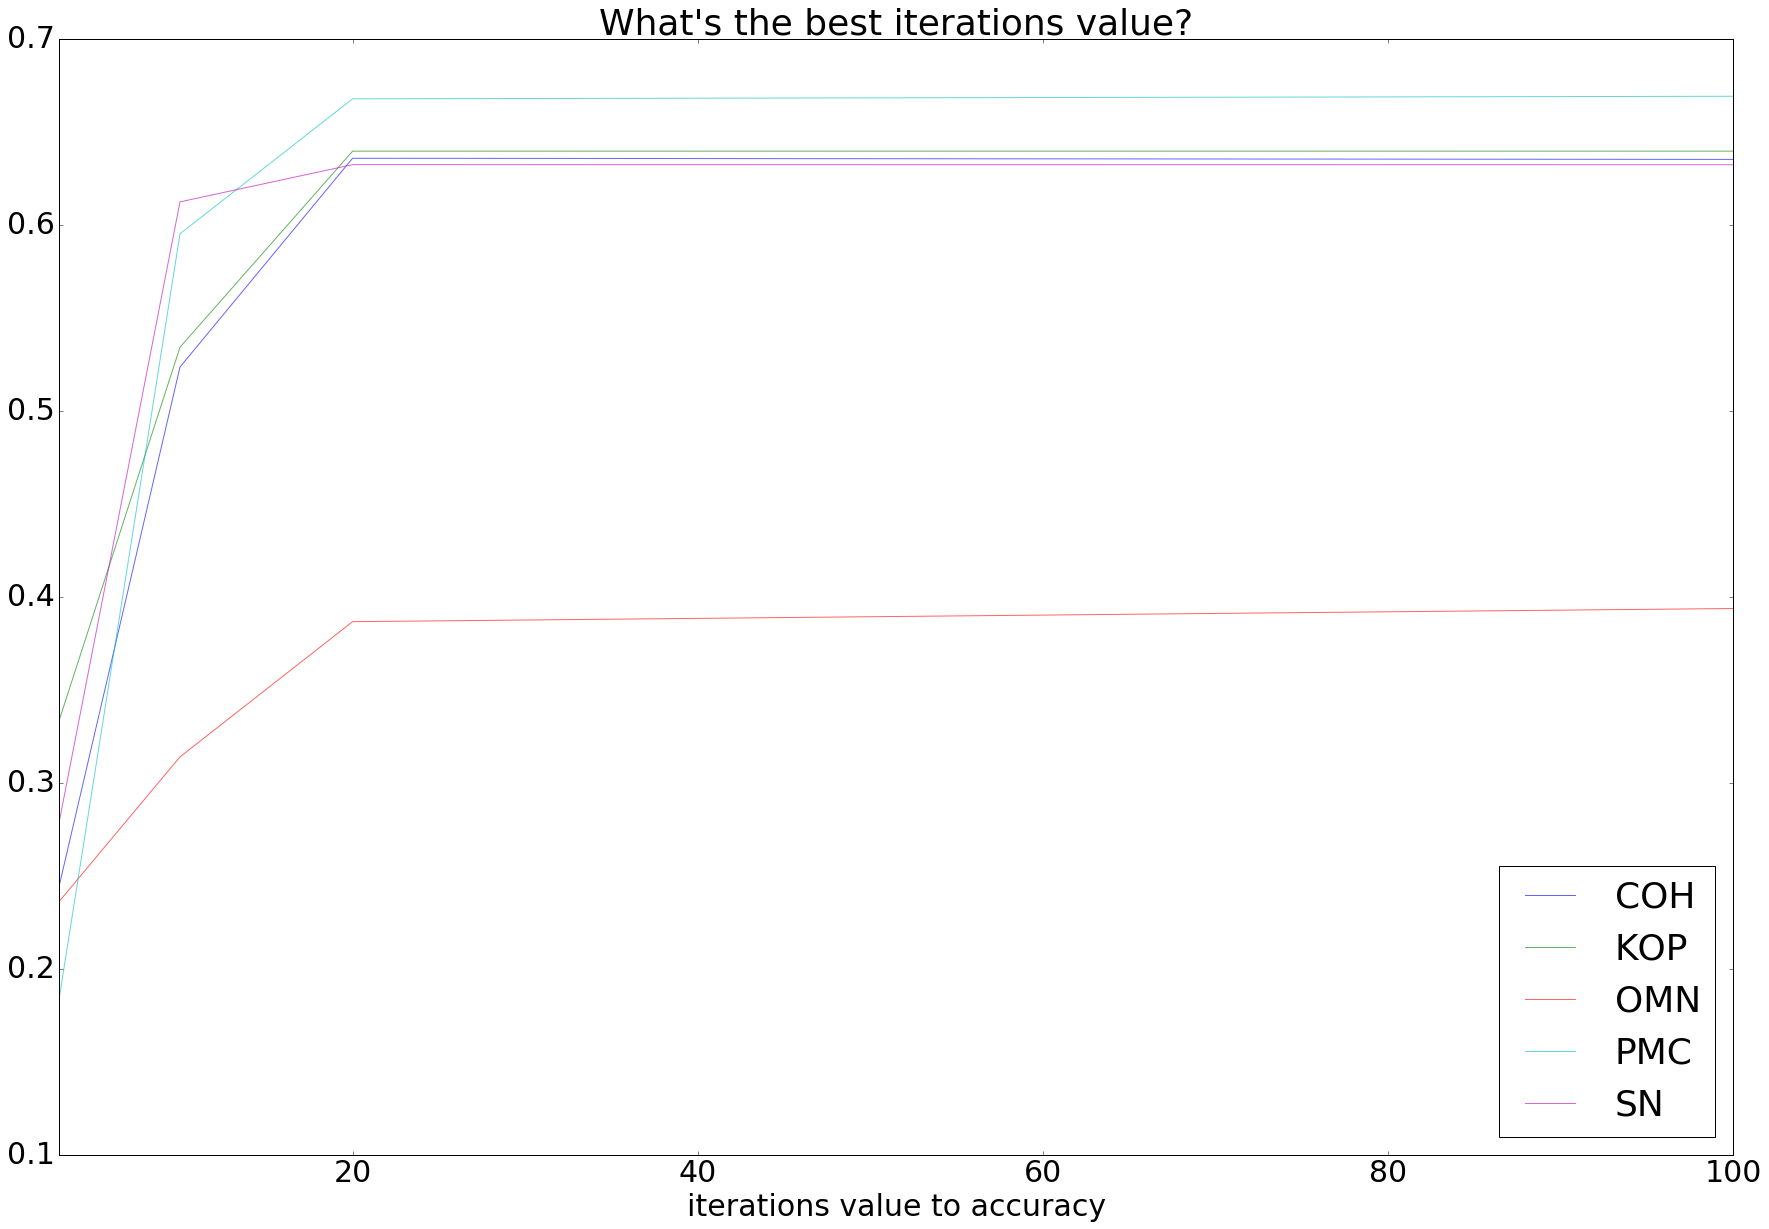

In [42]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('max_iter').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('iterations value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best iterations value?" )

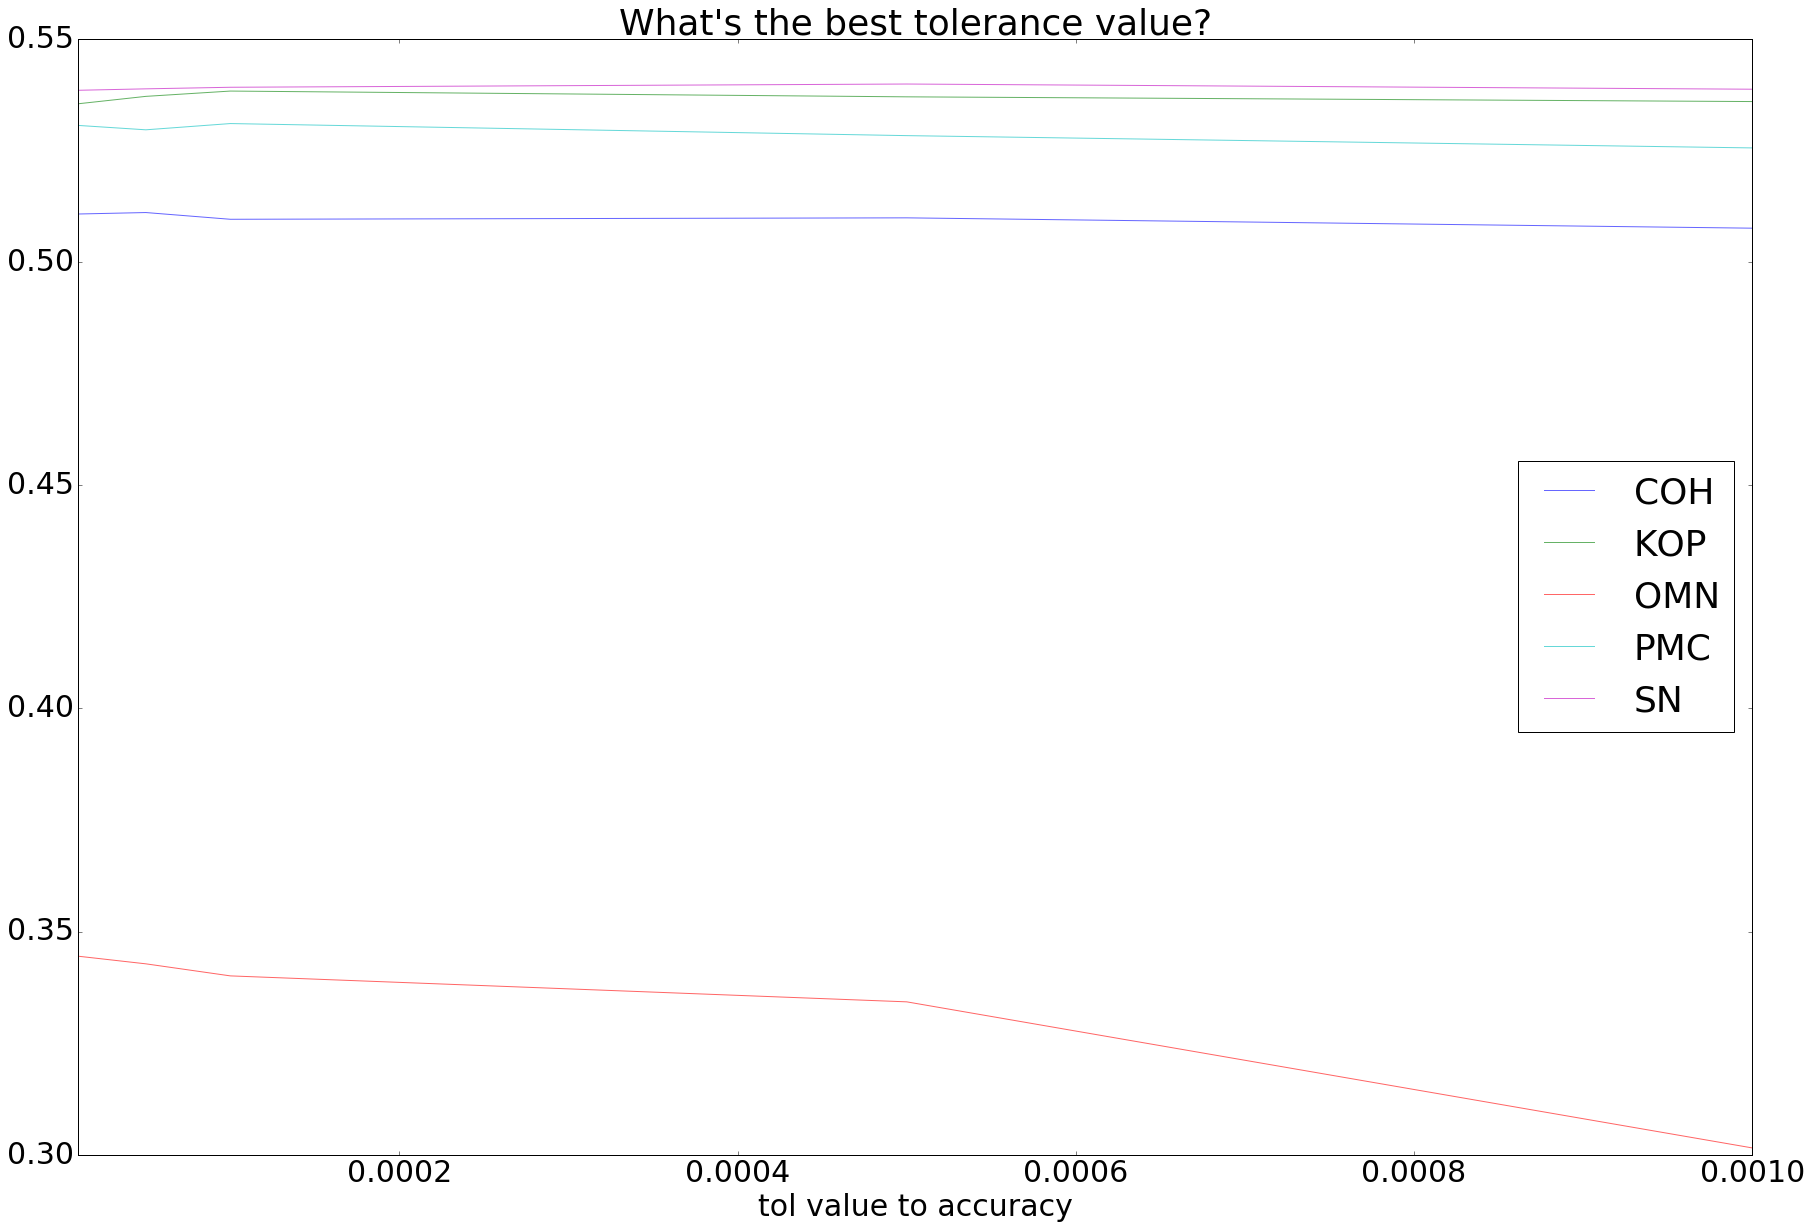

In [43]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in lresults.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('tol').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('tol value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best tolerance value?" )

In [31]:
print(get_best_model(lmodels, laccuracies))
print(get_best_median_model(lmodels, laccuracies))

(2.259468828215355, LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.0, max_iter=20, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))
(0.47468673788285298, LogisticRegression(C=0.5, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.3, max_iter=10, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))


## Results and improvments

So SVM and Trees aren't showing enough improvment to guarantee the convergence of Adaboost. So we will Try two things:
1. Change the threshold so the base accuracy will be higher.
2. play with Logistic Regression params to get better results, use it on the stocks it's strong enough to predict and work with that.

The first option is easy but will guarantee less profit. We will work with both until the end and find out wich is better.

### Changing the threshold

Will be done in a different notebook.

### Logistic Regression (Revisited)

As we saw before we want less regularization (as the models we are using are too weak) and we want more intercept scaling (bias correction). lower tols are better usually better so we will keep the lowest from before and l1 seems to behave better then l2.

In [37]:
# create iterables for all options and use itertools product

Cs = [0.1, 0.3, 0.5]
intercept_scalings = [1.3, 1.5 ,2.0, 5.0, 10.0]

l2models = [LogisticRegression(C=c, penalty='l1', max_iter=40, intercept_scaling=isc, tol=0.00007) 
          for c, isc, t in product(Cs, intercept_scalings, tols)]

In [38]:
l2accuracies = list(map(run_model, l2models))

In [39]:
from pandas import DataFrame

# data should be list of lists and each row should be:
# criterion, max_depth, min_samples, stock, accuracy
data = []
for model, accs in zip(l2models, l2accuracies):
    for sn, acc in accs.items():
        data.append((model.C, model.intercept_scaling, sn, acc))

l2results = DataFrame(data, columns=('C', 'intercept_scaling', 'stock', 'accuracy'))

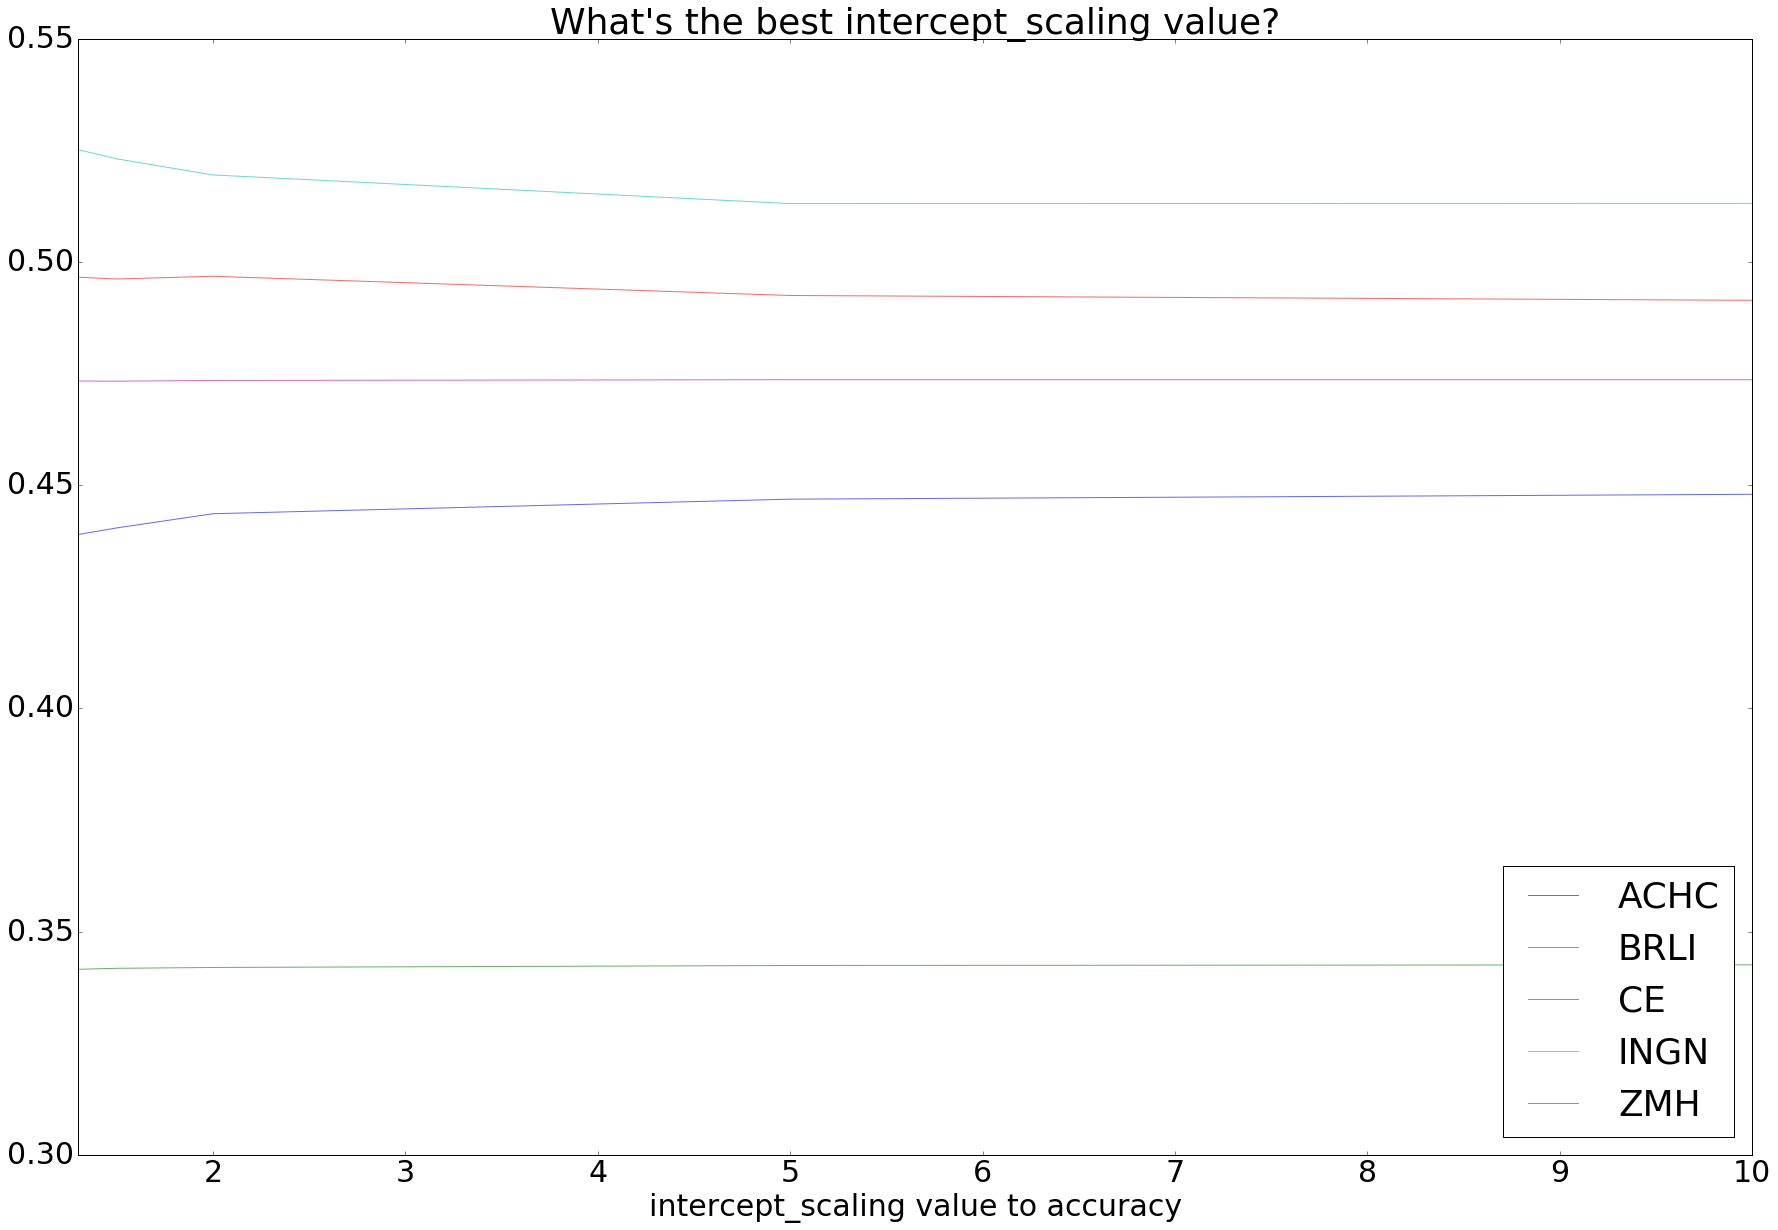

In [40]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in l2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('intercept_scaling').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('intercept_scaling value to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best intercept_scaling value?" )

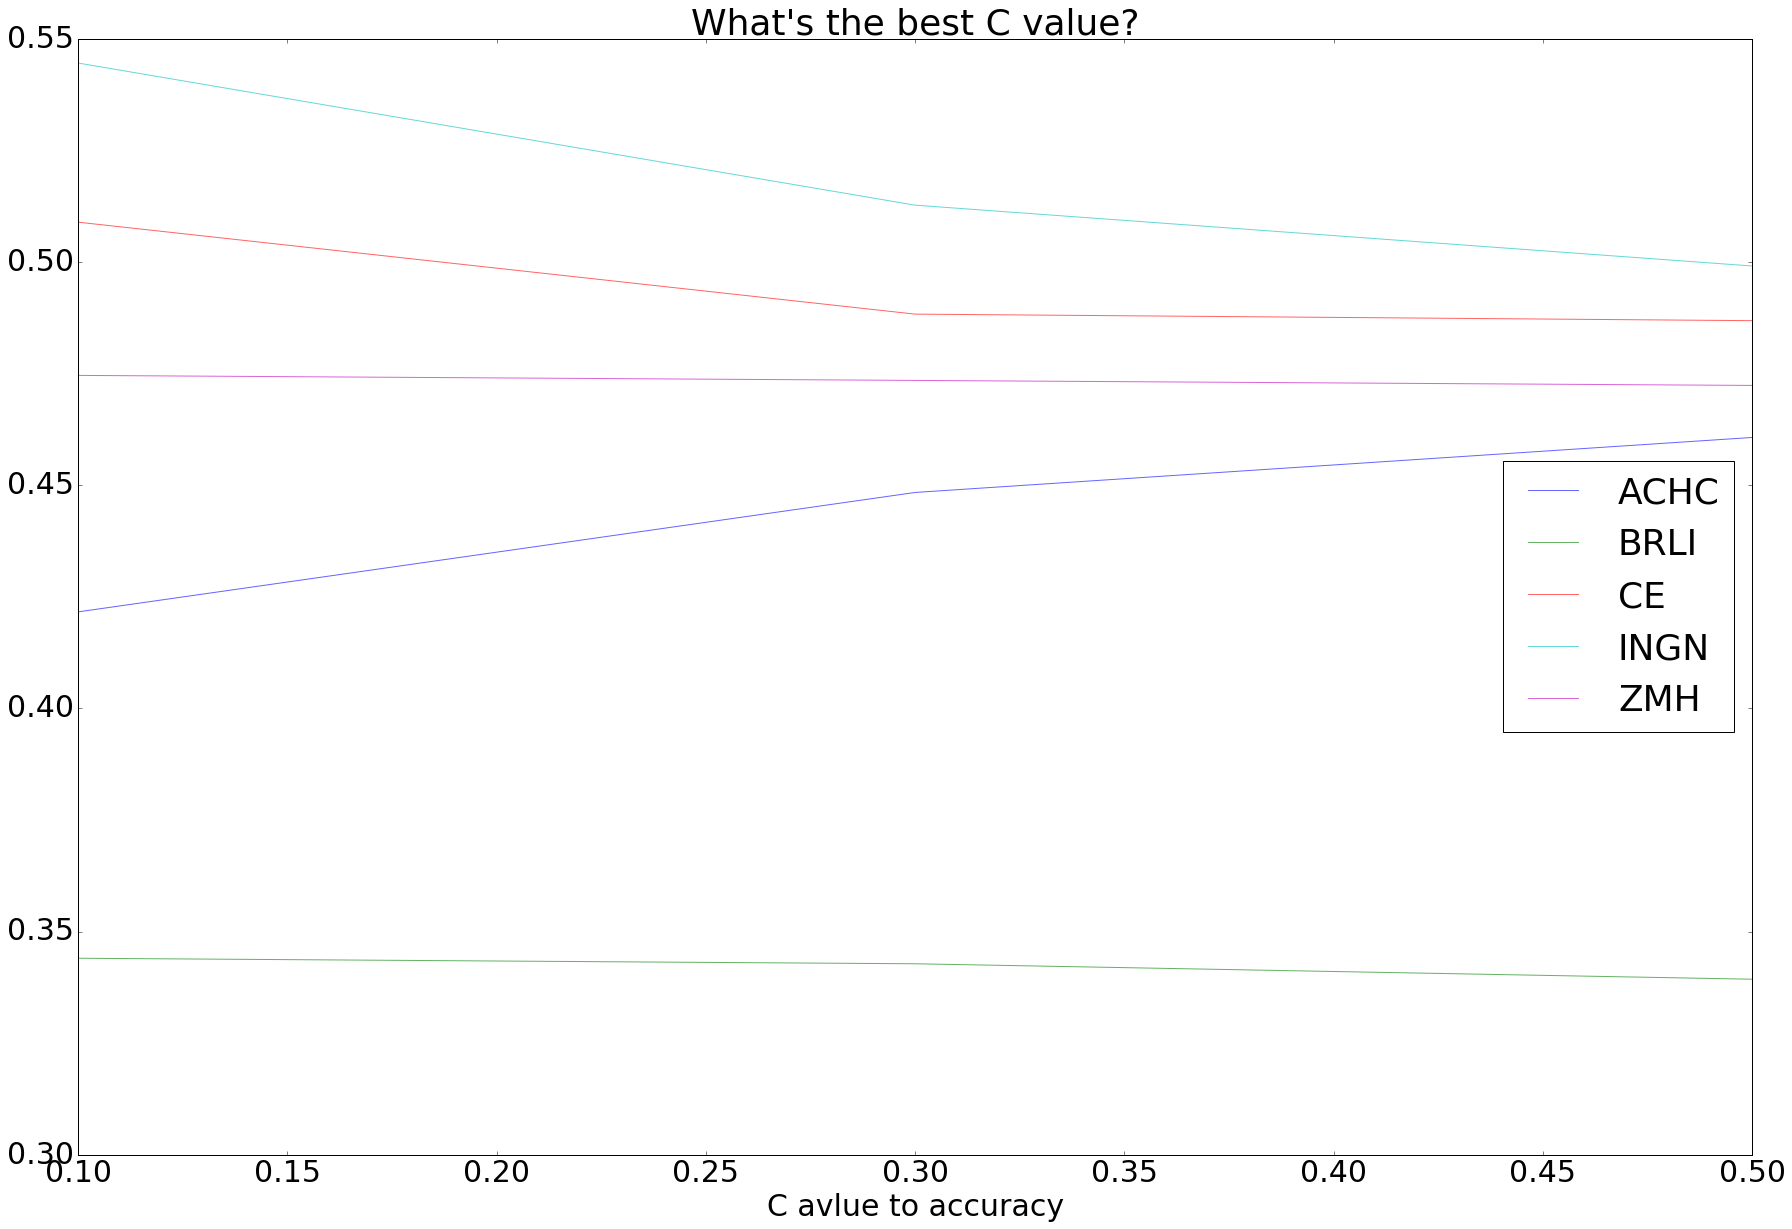

In [41]:
plt.rc('font', size=30)
fig = plt.figure(figsize=(30, 20))
alpha = 0.6

ax1 = plt.subplot2grid((1,1), (0,0))
for name, group in l2results.groupby('stock'):
    # since we are counting values it makes sense to regularize the counts
    group.groupby('C').agg('mean')['accuracy'].plot(kind='line', label=name, alpha=alpha)
ax1.set_xlabel('C avlue to accuracy')
plt.legend(loc='best')
ax1.set_title("What's the best C value?" )

In [42]:
print(get_best_model(l2models, l2accuracies))

(2.3019599111643658, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.3, max_iter=40, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))


Ok, So now just one last thing to check, it seems from the graph that although the mean of accuracies is lowest in logsitic regression the median is higher

In [43]:
print(get_best_median_model(l2models, l2accuracies))
print(get_best_model(l2models, l2accuracies))

(0.47487674121595536, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=5.0, max_iter=40, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))
(2.3019599111643658, LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1.3, max_iter=40, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=None, solver='liblinear', tol=7e-05,
          verbose=0, warm_start=False))


In [65]:
print(get_best_median_model(s2models, s2accuracies))
print(get_best_model(s2models, s2accuracies))

(0.98918717375093212, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))
(4.9029215014994296, SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='poly',
  max_iter=100, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False))


In [66]:
print(get_best_median_model(tmodels, taccuracies))
print(get_best_model(tmodels, taccuracies))

(0.98989898989898994, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.005,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))
(4.9070936020728038, DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=1,
            max_features=None, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=0.05,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best'))


# Conclusion

Amazingly logistic regression and decision tree have the same median. Trees proved to be the best classifier for this issue with a competition from both svm and logistic regression. For the next step (creating the AdaBosst ensemble) we will use all the models above (best avarage and best median) and we expect to see the tree giving the best results (also its training is much faster which will enable more estimators in adaboost).